In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import plotly.offline as pyoff
import plotly.graph_objs as go

import datetime as dt

import subprocess
import sys
import os
# !{sys.executable} -m pip install feature_engine
# !{sys.executable} -m pip install kneed
# !{sys.executable} -m pip install wordcloud
import feature_engine

from feature_engine.outliers import Winsorizer

import warnings
warnings.filterwarnings("ignore")

from yellowbrick.cluster import SilhouetteVisualizer

from wordcloud import WordCloud

In [2]:
from matplotlib.font_manager import FontProperties
montserrat_font = FontProperties(fname="Montserrat-Regular.ttf")
nunito_font = FontProperties(fname="NunitoSans_10pt-Regular.ttf")
dream_font = FontProperties(fname="dreamorp.ttf")

In [3]:
df = pd.read_csv("cc_dirty - cc_dirty.csv")

In [4]:
df.head()

,cc_num,gender,city,city_pop,job,dob,acct_num,acct_num2,trans_num,unix_time,category,amt
0,6.760000e+11,M,Dasmarinas,"659,019 people",Chartered loss adjuster,12/12/1958,798000000000,798000000000,a72eaa86b043eed95b25bbb25b3153a1,1581314011,shopping_net,$68.88
1,3.520000e+15,M,Digos,"169,393 people","Administrator, charities/voluntary organisations",31/08/1970,968000000000,968000000000,060d12f91c13871a13963041736a4702,1590902968,entertainment,$50.06
2,4.140000e+18,Male,Calapan,"133,893 people",Financial controller,23/07/1953,628000000000,628000000000,18aafb6098ab0923886c0ac83592ef8d,1585461157,food_dining,$105.44
3,4.870000e+15,M,San Fernando,"121,812 people",NaN,18/07/1964,863000000000,863000000000,45bbe714e51ab8a375454d39a190b0cb,1613063704,food_dining,$38.61
4,4.720000e+15,M,Laoag,"111,125 people",Dance movement psychotherapist,11/01/1954,257000000000,257000000000,c20ee88b451f637bc6893b7460e9fee0,1601282159,gas_transport,$82.69


In [5]:
df.columns

Index(['cc_num', 'gender', 'city', 'city_pop', 'job', 'dob', 'acct_num',
       'acct_num2', 'trans_num', 'unix_time', 'category', 'amt'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111877 entries, 0 to 111876
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   cc_num     111877 non-null  float64
 1   gender     111877 non-null  object 
 2   city       111877 non-null  object 
 3   city_pop   111877 non-null  object 
 4   job        103427 non-null  object 
 5   dob        111877 non-null  object 
 6   acct_num   111877 non-null  int64  
 7   acct_num2  111877 non-null  int64  
 8   trans_num  111877 non-null  object 
 9   unix_time  111877 non-null  int64  
 10  category   103318 non-null  object 
 11  amt        111877 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 10.2+ MB


# Data Cleaning

## Fix Data Types

In [7]:
# Standardize the values in the "gender" column
df['gender'] = df['gender'].replace({'Male': 'M', 'Female': 'F'})

In [8]:
# Convert the "city_pop" column to strings
df['city_pop']=pd.to_numeric(df['city_pop'].str.replace('people', '').str.replace(',', ''), errors='coerce')

In [9]:
# Convert the "dob" column to the datetime data type
df['dob'] = pd.to_datetime(df['dob'], errors='coerce')

In [10]:
# Drop "acct_num2" and Convert the "acct_num" column to strings to remove exponential format
df.drop(columns="acct_num2", inplace=True)
df['acct_num'] = df['acct_num'].astype(str)

In [11]:
# Convert the "unix_time" column to datetime with format "mm/dd/yy"
df['unix_time'] = pd.to_datetime(df['unix_time'], unit='s')

In [12]:
# Convert the "price" column to float
df['amt']=pd.to_numeric(df['amt'].str.replace('$', '').str.replace(',', ''), errors='coerce')

## Check Null Values

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111877 entries, 0 to 111876
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   cc_num     111877 non-null  float64       
 1   gender     111877 non-null  object        
 2   city       111877 non-null  object        
 3   city_pop   111877 non-null  int64         
 4   job        103427 non-null  object        
 5   dob        111877 non-null  datetime64[ns]
 6   acct_num   111877 non-null  object        
 7   trans_num  111877 non-null  object        
 8   unix_time  111877 non-null  datetime64[ns]
 9   category   103318 non-null  object        
 10  amt        111877 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(6)
memory usage: 9.4+ MB


In [14]:
job_null_count = df['job'].isnull().sum()
category_null_count = df['category'].isnull().sum()
total_null_count = df[['job', 'category']].isnull().sum().sum()


print("Total null values in 'job' column: {}".format(job_null_count.round(2)))
print("Total null values in 'category' column: {}".format(category_null_count.round(2)))
print("Total null values in 'job' and 'category' columns: {}".format(total_null_count.round(2)))

Total null values in 'job' column: 8450
Total null values in 'category' column: 8559
Total null values in 'job' and 'category' columns: 17009


In [15]:
# Compute number of rows with null value
print("Share of null values in 'job' column: {}%".format((100*(job_null_count/df.shape[0])).round(2)))
print("Share of null values in 'category' column: {}%".format((100*(category_null_count/df.shape[0])).round(2)))
print("Share of null values in 'job' and 'category' columns combined: {}%".format((100*(total_null_count/df.shape[0])).round(2)))

Share of null values in 'job' column: 7.55%
Share of null values in 'category' column: 7.65%
Share of null values in 'job' and 'category' columns combined: 15.2%


Dealing with Null Values: <br>
Since both 'job' and 'category' columns will not be used as main factors/variables to the study, we will retain null values and fill them with 'Not Indicated' values

In [16]:
# Replace null values in the "job" column with "No Job Indicated"
df['job'] = df['job'].fillna('No Job Indicated')
# Replace null values in the "category" column with "No Category Indicated"
df['category'].fillna('No Category Indicated', inplace=True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111877 entries, 0 to 111876
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   cc_num     111877 non-null  float64       
 1   gender     111877 non-null  object        
 2   city       111877 non-null  object        
 3   city_pop   111877 non-null  int64         
 4   job        111877 non-null  object        
 5   dob        111877 non-null  datetime64[ns]
 6   acct_num   111877 non-null  object        
 7   trans_num  111877 non-null  object        
 8   unix_time  111877 non-null  datetime64[ns]
 9   category   111877 non-null  object        
 10  amt        111877 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(6)
memory usage: 9.4+ MB


In [18]:
df.head()

,cc_num,gender,city,city_pop,job,dob,acct_num,trans_num,unix_time,category,amt
0,6.760000e+11,M,Dasmarinas,659019,Chartered loss adjuster,1958-12-12,798000000000,a72eaa86b043eed95b25bbb25b3153a1,2020-02-10 05:53:31,shopping_net,68.88
1,3.520000e+15,M,Digos,169393,"Administrator, charities/voluntary organisations",1970-08-31,968000000000,060d12f91c13871a13963041736a4702,2020-05-31 05:29:28,entertainment,50.06
2,4.140000e+18,M,Calapan,133893,Financial controller,1953-07-23,628000000000,18aafb6098ab0923886c0ac83592ef8d,2020-03-29 05:52:37,food_dining,105.44
3,4.870000e+15,M,San Fernando,121812,No Job Indicated,1964-07-18,863000000000,45bbe714e51ab8a375454d39a190b0cb,2021-02-11 17:15:04,food_dining,38.61
4,4.720000e+15,M,Laoag,111125,Dance movement psychotherapist,1954-11-01,257000000000,c20ee88b451f637bc6893b7460e9fee0,2020-09-28 08:35:59,gas_transport,82.69


# Check Duplicates

In [19]:
total_duplicates = df.duplicated().sum()
duplicates_share = ((total_duplicates)/df.shape[0])*100

print("Total Number of Duplicates: {}".format(total_duplicates))
print("Share of Duplicates: {}%".format(duplicates_share.round(2)))

Total Number of Duplicates: 11877
Share of Duplicates: 10.62%


In [20]:
#Drop duplicates since transactions should be unique
df.drop_duplicates(inplace=True)

In [21]:
df = df.reset_index(drop=True)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   cc_num     100000 non-null  float64       
 1   gender     100000 non-null  object        
 2   city       100000 non-null  object        
 3   city_pop   100000 non-null  int64         
 4   job        100000 non-null  object        
 5   dob        100000 non-null  datetime64[ns]
 6   acct_num   100000 non-null  object        
 7   trans_num  100000 non-null  object        
 8   unix_time  100000 non-null  datetime64[ns]
 9   category   100000 non-null  object        
 10  amt        100000 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(6)
memory usage: 8.4+ MB


New no. of rows: 100k

# Feature Engineering

In [23]:
# Calculate customer age from date_of_birth
df['dob'] = pd.to_datetime(df['dob'])
df['age'] = (pd.to_datetime('now') - df['dob']).astype('<m8[Y]')

In [24]:
# Extract Date, Month, and year of transactions
df['trans_date'] = df['unix_time'].dt.strftime('%Y-%m-%d')
df['trans_year'] = df['unix_time'].dt.strftime('%Y')
df['trans_month'] = df['unix_time'].dt.strftime('%b')

In [25]:
# Check for location behavior
df['is_ncr'] = df['city'].apply(lambda x: 1 if x in ['City of Parañaque','Malabon','Makati City','City of Calamba','Manila','Muntinlupa City','Olongapo','Valenzuela','Caloocan City','San Jose del Monte','Imus','San Juan','Mandaluyong City'] else 0)

In [26]:
# Separate net and pos data
df['gen_cat'] = df['category'].apply(lambda x: 'Net' if '_net' in x  else ('POS' if 'pos' in x else 'Other'))

# EDA

In [27]:
def set_chart_properties(title,x_label,y_label,legend_title):
    sns.set(style="whitegrid")
    # Set plot labels and title
    plt.xlabel(x_label,fontproperties=nunito_font, fontsize=14)
    plt.ylabel(y_label,fontproperties=nunito_font, fontsize=14)
    plt.title(title,fontproperties=dream_font, fontsize=20)

    # Show the legend
    plt.legend(title=legend_title, loc='upper right', prop=nunito_font)

    plt.xticks(fontproperties=nunito_font, fontsize=12)
    plt.yticks(fontproperties=nunito_font, fontsize=12)

    plt.grid(False)
    

# Descriptive Statistics

In [28]:
df.describe()

,cc_num,city_pop,amt,age,is_ncr
count,1.000000e+05,1.000000e+05,100000.000000,100000.00000,100000.000000
mean,3.768208e+17,4.542336e+05,70.292041,68.19138,0.163160
std,1.231884e+18,1.931346e+06,183.991890,10.46977,0.369513
min,6.049060e+10,4.104100e+04,1.000000,53.00000,0.000000
25%,3.800000e+13,1.338930e+05,8.740000,60.00000,0.000000
50%,3.520000e+15,2.330400e+05,49.160000,66.00000,0.000000
75%,4.620000e+15,3.537670e+05,85.442500,74.00000,0.000000
max,4.830000e+18,2.308800e+07,18039.810000,97.00000,1.000000


# Age

In [29]:
df_agg = df[df['gen_cat'] != 'Other'].groupby(['acct_num']).agg({'age':'mean'}).reset_index()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


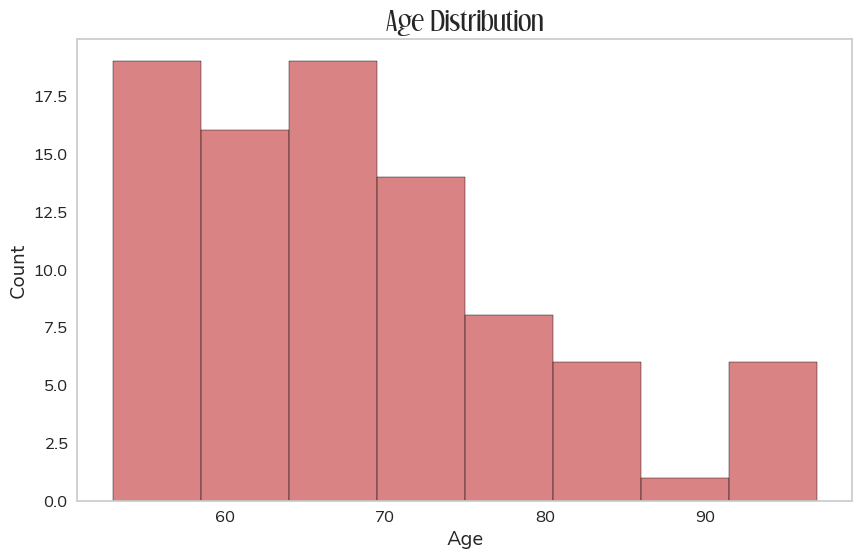

In [30]:
plt.figure(figsize=(10, 6)) 

sns.histplot(x='age', data=df_agg, color='#CD595B')

set_chart_properties("Age Distribution","Age","Count","")

plt.show()

In [31]:
print("Age range is {} to {}, with a average value of {}".format(df_agg['age'].min(), df_agg['age'].max(),df_agg['age'].mean().round(2)))

Age range is 53.0 to 97.0, with a average value of 68.42


## Transactions per category YoY

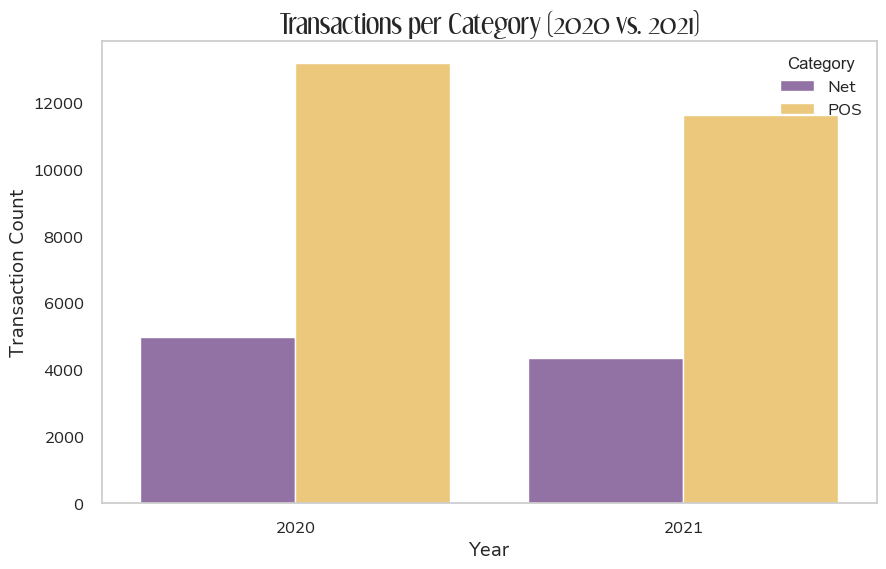

In [32]:
plt.figure(figsize=(10, 6)) 
bar_colors = ['#9468AC', '#FECE6B']

sns.countplot(x='trans_year', hue='gen_cat', data=df[df['gen_cat']!='Other'], palette=bar_colors)

set_chart_properties("Transactions per Category (2020 vs. 2021)","Year","Transaction Count","Category")

plt.show()

In [33]:
df_pos_net = df[df['gen_cat']!='Other']

In [34]:
df_pos_net_agg  = df_pos_net.groupby(['trans_year','gen_cat']).agg({'trans_num':'count'}).reset_index()
df_pos_net_agg

,trans_year,gen_cat,trans_num
0,2020,Net,4985
1,2020,POS,13178
2,2021,Net,4359
3,2021,POS,11628


In [35]:
pos_2020 = df_pos_net_agg.loc[(df_pos_net_agg['trans_year'] == '2020') & (df_pos_net_agg['gen_cat'] == 'POS'), 'trans_num'].sum()
net_2020 = df_pos_net_agg.loc[(df_pos_net_agg['trans_year'] == '2020') & (df_pos_net_agg['gen_cat'] == 'Net'), 'trans_num'].sum()
result_2020 = pos_2020 / net_2020 - 1
print(" POS has {}% more purchases compared to Net in 2020".format(100*result_2020.round(2)))

 POS has 164.0% more purchases compared to Net in 2020


In [36]:
pos_2021 = df_pos_net_agg.loc[(df_pos_net_agg['trans_year'] == '2021') & (df_pos_net_agg['gen_cat'] == 'POS'), 'trans_num'].sum()
net_2021 = df_pos_net_agg.loc[(df_pos_net_agg['trans_year'] == '2021') & (df_pos_net_agg['gen_cat'] == 'Net'), 'trans_num'].sum()
result_2021 = pos_2021 / net_2021 - 1
print(" POS has {}% more purchases compared to Net in 2021".format(100*result_2021.round(2)))

 POS has 167.0% more purchases compared to Net in 2021


In terms of volume or number of transactions, POS or onsite transaction far exceeds number of Net or online transaction (more than 1.5x)

# Average Spent per Transaction

In [37]:
average_spent_per_category = df.groupby(['trans_year', 'gen_cat'])['amt'].mean().reset_index()

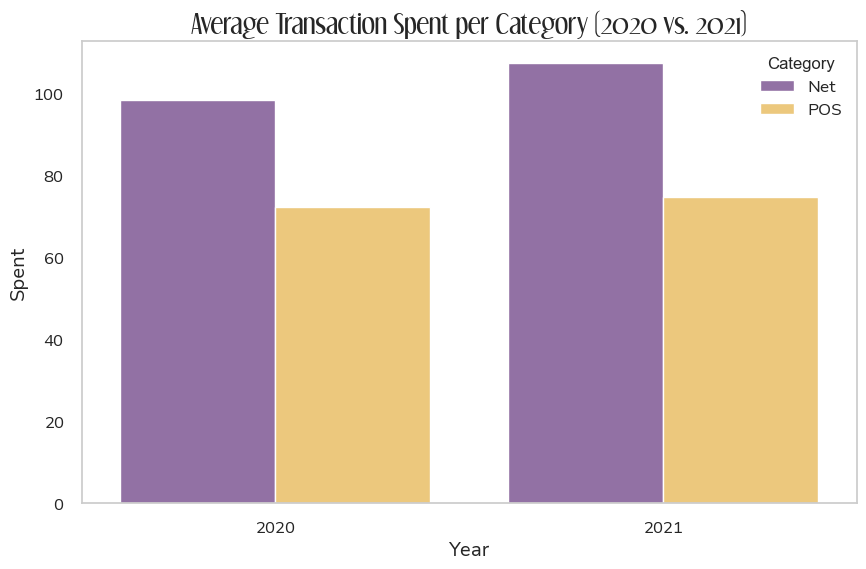

In [38]:
plt.figure(figsize=(10, 6)) 
bar_colors = ['#9468AC', '#FECE6B']

sns.barplot(x='trans_year', y='amt', hue='gen_cat', data=average_spent_per_category[average_spent_per_category['gen_cat']!='Other'], palette=bar_colors)

set_chart_properties("Average Transaction Spent per Category (2020 vs. 2021)","Year","Spent","Category")

plt.show()

In [39]:
average_spent_per_category

,trans_year,gen_cat,amt
0,2020,Net,98.451862
1,2020,Other,64.104438
2,2020,POS,72.326088
3,2021,Net,107.352856
4,2021,Other,64.984150
5,2021,POS,74.729534


In [40]:
pos_2020 = average_spent_per_category.loc[(average_spent_per_category['trans_year'] == '2020') & (average_spent_per_category['gen_cat'] == 'POS'), 'amt'].sum()
net_2020 = average_spent_per_category.loc[(average_spent_per_category['trans_year'] == '2020') & (average_spent_per_category['gen_cat'] == 'Net'), 'amt'].sum()
result_2020 = net_2020/pos_2020 - 1
print("Customers are spending {}% higher on Net purchases vs POS in 2020".format(100*result_2020.round(2)))

Customers are spending 36.0% higher on Net purchases vs POS in 2020


In [41]:
pos_2021 = average_spent_per_category.loc[(average_spent_per_category['trans_year'] == '2021') & (average_spent_per_category['gen_cat'] == 'POS'), 'amt'].sum()
net_2021 = average_spent_per_category.loc[(average_spent_per_category['trans_year'] == '2021') & (average_spent_per_category['gen_cat'] == 'Net'), 'amt'].sum()
result_2021 = net_2021/pos_2021 - 1
print("Customers are spending {}% higher on Net purchases vs POS in 2021".format(100*result_2021.round(2)))

Customers are spending 44.0% higher on Net purchases vs POS in 2021


In terms of spending, average spent per transaction for Net purchases are almost 40% higher compared to POS

# Average Spent per Capita

In [42]:
spent_per_capita = df.groupby(['trans_year', 'gen_cat']).agg({'amt':'sum','acct_num':'nunique'}).reset_index()
spent_per_capita.rename(columns={'amt':'total_amount','acct_num':'unique_cust'}, inplace=True)

In [43]:
spent_per_capita['amt_per_cust'] = spent_per_capita['total_amount']/spent_per_capita['unique_cust']

In [44]:
spent_per_capita

,trans_year,gen_cat,total_amount,unique_cust,amt_per_cust
0,2020,Net,490782.53,73,6723.048356
1,2020,Other,2244680.99,72,31176.124861
2,2020,POS,953113.19,73,13056.345068
3,2021,Net,467951.10,82,5706.720732
4,2021,Other,2003721.27,82,24435.625244
5,2021,POS,868955.02,83,10469.337590


In [45]:
# Calculate quartiles and IQR
Q1 = df['amt'].quantile(0.25)
Q3 = df['amt'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for identifying outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers and create a new DataFrame
df_no_outliers = df[(df['amt'] >= lower_bound) & (df['amt'] <= upper_bound)]

In [46]:
spent_per_capita = df_no_outliers.groupby(['trans_year', 'gen_cat']).agg({'amt':'sum','acct_num':'nunique'}).reset_index()
spent_per_capita.rename(columns={'amt':'total_amount','acct_num':'unique_cust'}, inplace=True)

In [47]:
spent_per_capita['amt_per_cust'] = spent_per_capita['total_amount']/spent_per_capita['unique_cust']

In [48]:
spent_per_capita[spent_per_capita['gen_cat']!='Other']

,trans_year,gen_cat,total_amount,unique_cust,amt_per_cust
0,2020,Net,160388.59,67,2393.859552
2,2020,POS,575667.86,68,8465.703824
3,2021,Net,138990.63,67,2074.487015
5,2021,POS,497291.47,71,7004.105211


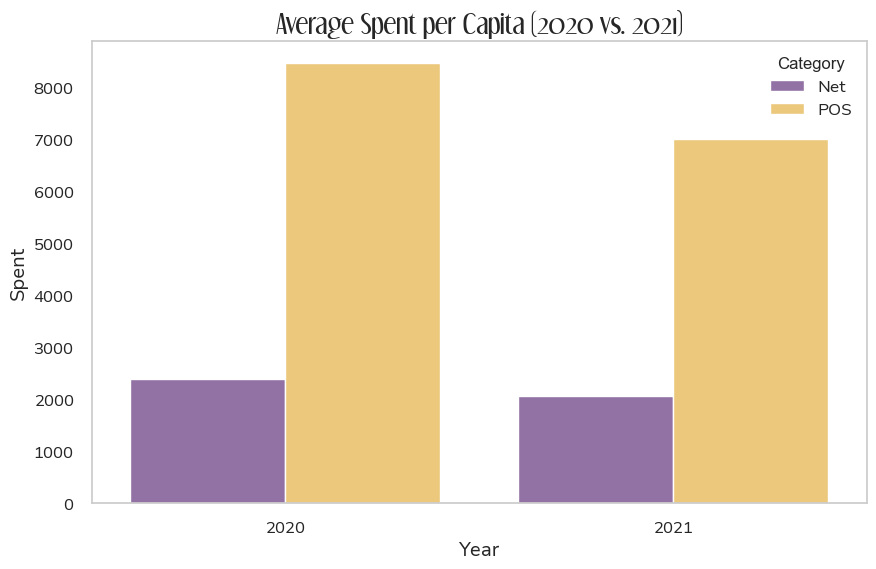

In [49]:
plt.figure(figsize=(10, 6)) 
bar_colors = ['#9468AC', '#FECE6B']

sns.barplot(x='trans_year', y='amt_per_cust', hue='gen_cat', data=spent_per_capita[spent_per_capita['gen_cat']!='Other'], palette=bar_colors)

set_chart_properties("Average Spent per Capita (2020 vs. 2021)","Year","Spent","Category")

plt.show()

# Spend Analysis: Net vs. POS

Spent Per Transaction (Net > POS)
- Net custs tend to spend more money each time they make a transaction, which means that when they make a purchase, the amount spent is higher on average compared to POS custs This could imply that Net custs makes larger individual purchases or transactions.
<br>
<br>
Spend per Capita (POS > Net)
- This means that, on average, each person in POS group spends more money over a certain period than each person in Net group. This could be due to higher frequency of transactions (see trans graph).
<br>
<br>
Hypothesis:
- Net may represent customers who make occasional but substantial purchases, such as buying expensive items or services.
- POS may consist of a customer base who make more frequent but smaller purchases.
<br>
<br>
For the next steps, we need to gain deeper insights and understand underlying factors that can help the business tailor their marketing strategies, product offerings, and customer engagement efforts to better serve the unique preferences and behaviors of each group

## Checking Significant Difference

In [50]:
import scipy.stats as stats

group1 = [25, 30, 35, 40, 45]
group2 = [15, 20, 22, 28, 32]

# Perform the Mann-Whitney U test
U_statistic, p_value = stats.mannwhitneyu(df_pos_net[df_pos_net['gen_cat']=='POS']['amt'], df_pos_net[df_pos_net['gen_cat']=='Net']['amt'], alternative='two-sided')

alpha = 0.05 
if p_value < alpha:
    print(f'The difference between groups is significant (p-value: {p_value})')
else:
    print(f'The difference between groups is not significant (p-value: {p_value})')

The difference between groups is significant (p-value: 1.8909819625518947e-07)


Since p value < 0.05 we can say that the difference between Net v. POS is statistically meaningful and warrants further investigation

** note: mannwhitney for non-normal groups

# RFM Analysis

For a sample size of 89 customers, it was considered starting with 3 bins for each RFM component, which would give you 3^3 = 27 segments. This provides a reasonable level of granularity without creating an overwhelming number of segments.

## Filtered to Net Customers

In [51]:
df_net = df[df['gen_cat']=='POS']

In [52]:
df_net.describe()

,cc_num,city_pop,amt,age,is_ncr
count,2.480600e+04,2.480600e+04,24806.000000,24806.000000,24806.000000
mean,3.706805e+17,4.582500e+05,73.452722,68.167258,0.162179
std,1.223392e+18,1.965203e+06,150.855656,10.443604,0.368622
min,6.049060e+10,4.104100e+04,1.000000,53.000000,0.000000
25%,3.690000e+13,1.338930e+05,5.680000,60.000000,0.000000
50%,3.520000e+15,2.090830e+05,32.130000,66.000000,0.000000
75%,4.620000e+15,3.537670e+05,91.780000,74.000000,0.000000
max,4.830000e+18,2.308800e+07,3371.310000,97.000000,1.000000


In [53]:
df_net.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24806 entries, 14 to 99999
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   cc_num       24806 non-null  float64       
 1   gender       24806 non-null  object        
 2   city         24806 non-null  object        
 3   city_pop     24806 non-null  int64         
 4   job          24806 non-null  object        
 5   dob          24806 non-null  datetime64[ns]
 6   acct_num     24806 non-null  object        
 7   trans_num    24806 non-null  object        
 8   unix_time    24806 non-null  datetime64[ns]
 9   category     24806 non-null  object        
 10  amt          24806 non-null  float64       
 11  age          24806 non-null  float64       
 12  trans_date   24806 non-null  object        
 13  trans_year   24806 non-null  object        
 14  trans_month  24806 non-null  object        
 15  is_ncr       24806 non-null  int64         
 16  gen

## Net: Rule based-RFM

In [54]:
from datetime import datetime, timedelta

snapshot_date = max(df_net['unix_time']) + timedelta(days=1)
snapshot_date

Timestamp('2021-12-07 11:29:44')

In [55]:
# Aggregate data on a 'acct_num' level and compute rfm
df_net_agg = df_net.groupby(['acct_num']).agg({
    'unix_time': lambda x: (snapshot_date - x.max()).days,
    'trans_num': 'count',
    'amt': ['sum']
})
df_net_agg.columns = ['Recency','Frequency','Monetary']

In [56]:
df_net_agg.head()

,Recency,Frequency,Monetary
acct_num,,,
124000000000,1,546,34281.67
138000000000,379,1,286.41
169000000000,117,5,1201.48
170000000000,1,521,37966.54
201000000000,3,179,13260.67


In [57]:
# Check 1 day recency count
df_net[df_net['unix_time']>='2021-12-06 00:00:00']['acct_num'].nunique()

31

In [58]:
df_net_agg[df_net_agg['Recency']==1].sum()

Recency           34.00
Frequency      15093.00
Monetary     1097039.64
dtype: float64

### Recency

In [61]:
recency_groups = pd.cut(df_net_agg['Recency'],
                   bins=3,
                   labels=[3, 2, 1])

df_net_agg = df_net_agg.assign(R=recency_groups.values)
df_net_agg.head()

,Recency,Frequency,Monetary,R
acct_num,,,,
124000000000,1,546,34281.67,3
138000000000,379,1,286.41,2
169000000000,117,5,1201.48,3
170000000000,1,521,37966.54,3
201000000000,3,179,13260.67,3


### Frequency

In [62]:
frequency_groups = pd.qcut(df_net_agg['Frequency'],
                   q=3,
                   labels=[1,2,3])

df_net_agg = df_net_agg.assign(F=recency_groups.values)
df_net_agg.head()

,Recency,Frequency,Monetary,R,F
acct_num,,,,,
124000000000,1,546,34281.67,3,3
138000000000,379,1,286.41,2,2
169000000000,117,5,1201.48,3,3
170000000000,1,521,37966.54,3,3
201000000000,3,179,13260.67,3,3


### Monetary

In [63]:
monetary_groups = pd.qcut(df_net_agg['Monetary'],
                   q=3,
                   labels=[1, 2, 3])

# Create new column M
df_net_agg = df_net_agg.assign(M=monetary_groups)
df_net_agg.head()

,Recency,Frequency,Monetary,R,F,M
acct_num,,,,,,
124000000000,1,546,34281.67,3,3,3
138000000000,379,1,286.41,2,2,1
169000000000,117,5,1201.48,3,3,1
170000000000,1,521,37966.54,3,3,3
201000000000,3,179,13260.67,3,3,2


### Compute RFM Score

In [66]:
df_net_agg['RFM_Score'] = df_net_agg[['R','F','M']].sum(axis=1)
df_net_agg.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Score
acct_num,,,,,,,
124000000000,1,546,34281.67,3,3,3,9
138000000000,379,1,286.41,2,2,1,5
169000000000,117,5,1201.48,3,3,1,7
170000000000,1,521,37966.54,3,3,3,9
201000000000,3,179,13260.67,3,3,2,8


In [67]:
df_net_agg['RFM_Score'].max()

9

### RFM Level Function

In [70]:
def rfm_level(df):
    if df['RFM_Score'] >= 8:
        return 'Top'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 8)):
        return 'Middle'
    else:
        return 'Low'

# Create a new variable RFM_Level
df_net_agg['RFM_Level'] = df_net_agg.apply(rfm_level, axis=1)

df_net_agg.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Score,RFM_Level
acct_num,,,,,,,,
124000000000,1,546,34281.67,3,3,3,9,Top
138000000000,379,1,286.41,2,2,1,5,Middle
169000000000,117,5,1201.48,3,3,1,7,Middle
170000000000,1,521,37966.54,3,3,3,9,Top
201000000000,3,179,13260.67,3,3,2,8,Top


In [71]:
df_net_agg.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count'] }).round(1)

Recency Frequency Monetary      
             mean      mean     mean count
RFM_Level                                 
Low         580.0       4.0   1872.0     5
Middle      140.1      51.4   4347.8    25
Top           2.0     398.3  28881.6    59

# Net: Kmeans Clustering

## Data Pre-processing

### Skewness

In [72]:
## Function to check skewness
def check_skew(df_skew, column):
    sns.set(style="whitegrid")
    plt.xlabel(column, fontproperties=nunito_font, fontsize=14)
    plt.ylabel('Density', fontproperties=nunito_font, fontsize=14)
    plt.title('Distribution of ' + column, fontproperties=dream_font, fontsize=20)

    plt.xticks(fontproperties=nunito_font, fontsize=12)
    plt.yticks(fontproperties=nunito_font, fontsize=12)
    plt.grid(False)
    
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    sns.distplot(df_skew[column], color='#9468AC')
    return

Recency's: Skew: 2.427942673770814, : SkewtestResult(statistic=6.436954109101367, pvalue=1.2189476716715937e-10)
Frequency's: Skew: 0.6154825647597074, : SkewtestResult(statistic=2.3795741422804384, pvalue=0.01733265582804695)
Monetary's: Skew: 0.5958232431415605, : SkewtestResult(statistic=2.311876240897263, pvalue=0.020784504385283634)


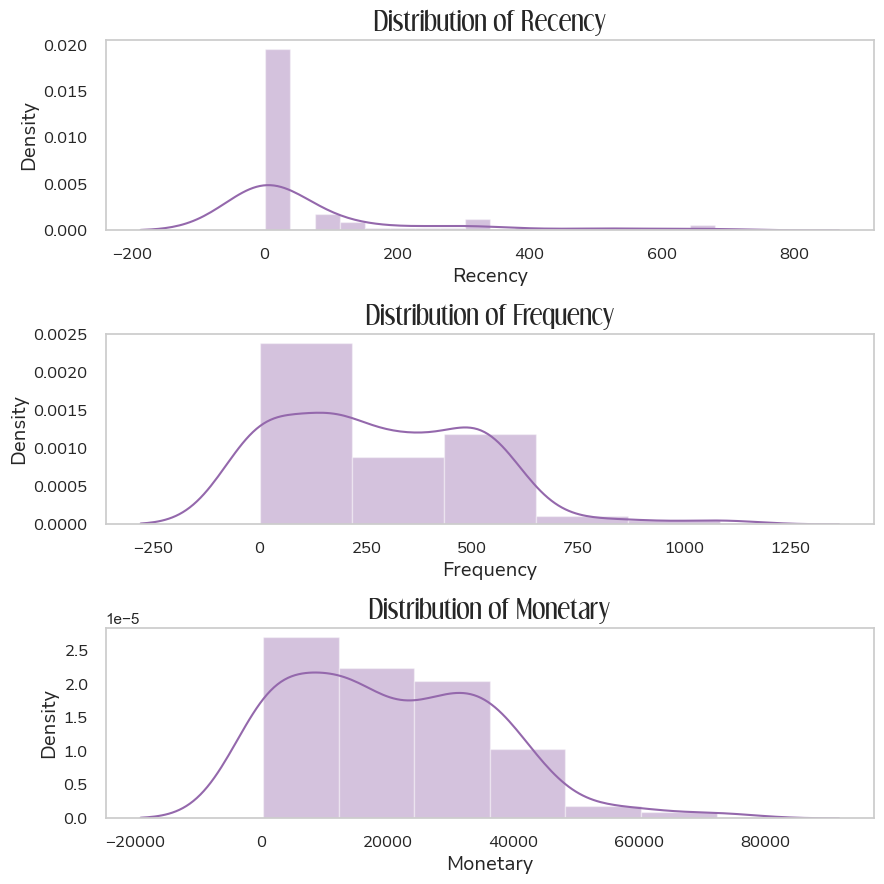

In [73]:
# Plot all 3 graphs together for summary findings

plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(df_net_agg,'Recency')

plt.subplot(3, 1, 2)
check_skew(df_net_agg,'Frequency')

plt.subplot(3, 1, 3)
check_skew(df_net_agg,'Monetary')

plt.tight_layout()

 - Recency's: The skewness of 2.448 suggests a right-skewed distribution. To make it more normally distributed, you can try applying a logarithmic transformation or a square root transformation to the data. You may also want to check for outliers and consider removing or transforming them.
<br><br>
- Frequency's: The skewness of 0.564 suggests a mild right skew. You can try a logarithmic transformation or a square root transformation to make it more normally distributed. Additionally, consider checking for outliers and addressing them if necessary.
<br><br>
 - Monetary's: The skewness of 0.922 indicates a moderate right skew. Similar to the other variables, you can apply a logarithmic transformation or a square root transformation to make it more normally distributed. Also, check for outliers and address them as needed.

### Data Transformation (Use Box-Cox)

### Log Transform

In [74]:
df_net_rfm_log = df_net_agg[['Recency','Frequency','Monetary']]

Recency's: Skew: 1.0381044617256139, : SkewtestResult(statistic=3.677146626085316, pvalue=0.0002358574803580573)
Frequency's: Skew: -1.0221471716547792, : SkewtestResult(statistic=-3.6333503970845693, pvalue=0.0002797646842129417)
Monetary's: Skew: -1.0695679113127976, : SkewtestResult(statistic=-3.7624024577479536, pvalue=0.000168288951303879)


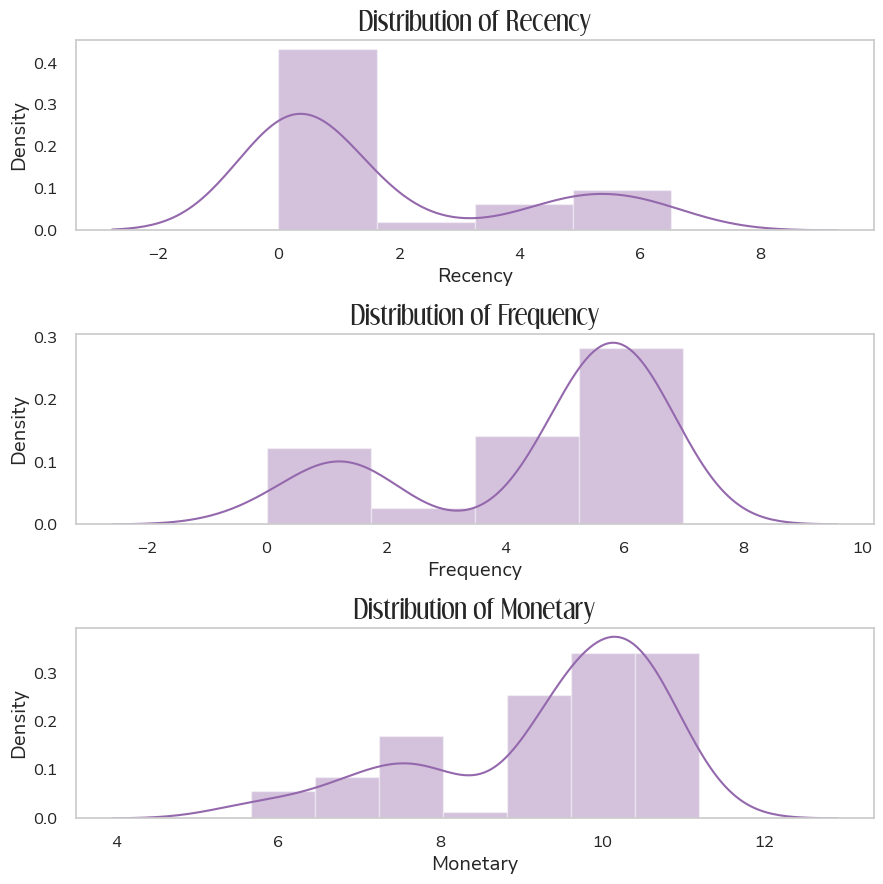

In [75]:
df_rfm_log = np.log(df_net_rfm_log)

plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(df_rfm_log,'Recency')

plt.subplot(3, 1, 2)
check_skew(df_rfm_log,'Frequency')

plt.subplot(3, 1, 3)
check_skew(df_rfm_log,'Monetary')

plt.tight_layout()

### Square root

In [76]:
df_net_rfm_sqrt = df_net_agg[['Recency','Frequency','Monetary']]
df_net_rfm_sqrt = np.sqrt(df_net_rfm_sqrt)

Recency's: Skew: 1.6305014463979048, : SkewtestResult(statistic=5.070235218197825, pvalue=3.973243375368925e-07)
Frequency's: Skew: -0.34594491409392303, : SkewtestResult(statistic=-1.3954708006266716, pvalue=0.1628739140374441)
Monetary's: Skew: -0.21944330754476335, : SkewtestResult(statistic=-0.8969504971832433, pvalue=0.3697453326559651)


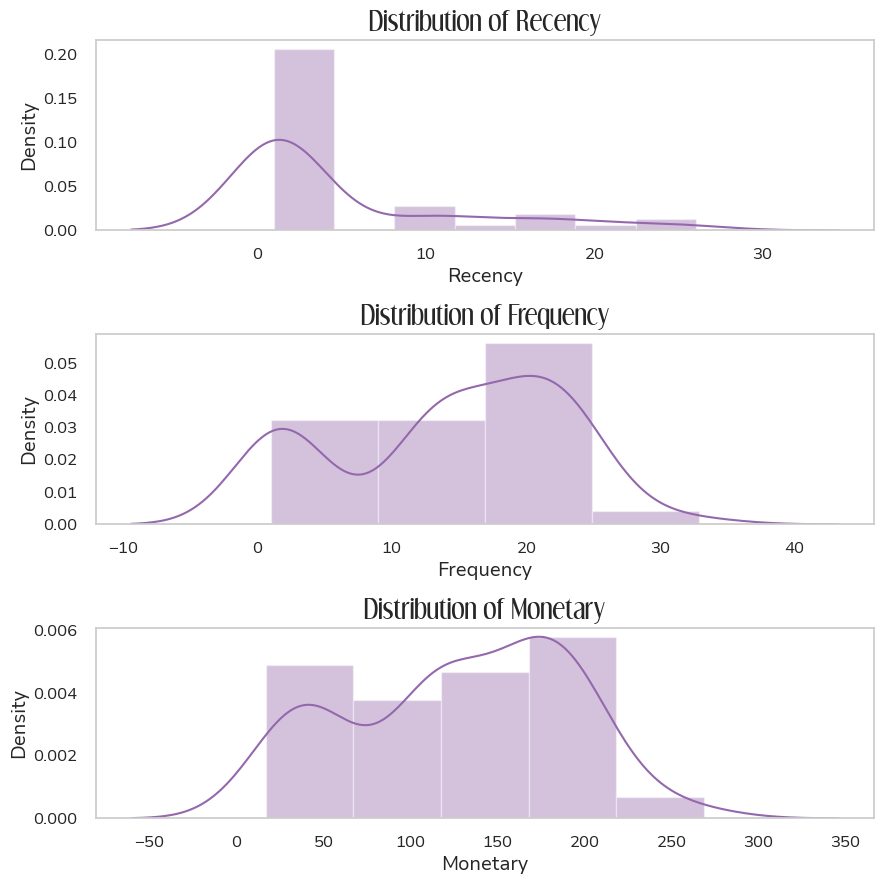

In [77]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(df_net_rfm_sqrt,'Recency')

plt.subplot(3, 1, 2)
check_skew(df_net_rfm_sqrt,'Frequency')

plt.subplot(3, 1, 3)
check_skew(df_net_rfm_sqrt,'Monetary')

plt.tight_layout()

### Box cox

In [78]:
df_net_rfm_bc = df_net_agg[['Recency','Frequency','Monetary']]

df_net_rfm_bc['Recency'] = stats.boxcox(df_net_agg['Recency'])[0]
df_net_rfm_bc['Frequency'] = stats.boxcox(df_net_agg['Frequency'])[0]
df_net_rfm_bc['Monetary'] = stats.boxcox(df_net_agg['Monetary'])[0]

Recency's: Skew: 0.5858640941559521, : SkewtestResult(statistic=2.27732729947071, pvalue=0.022766687897240782)
Frequency's: Skew: -0.47832629820862127, : SkewtestResult(statistic=-1.8935345784044268, pvalue=0.05828681430003459)
Monetary's: Skew: -0.2779835620699928, : SkewtestResult(statistic=-1.1300346700123958, pvalue=0.2584616158248223)


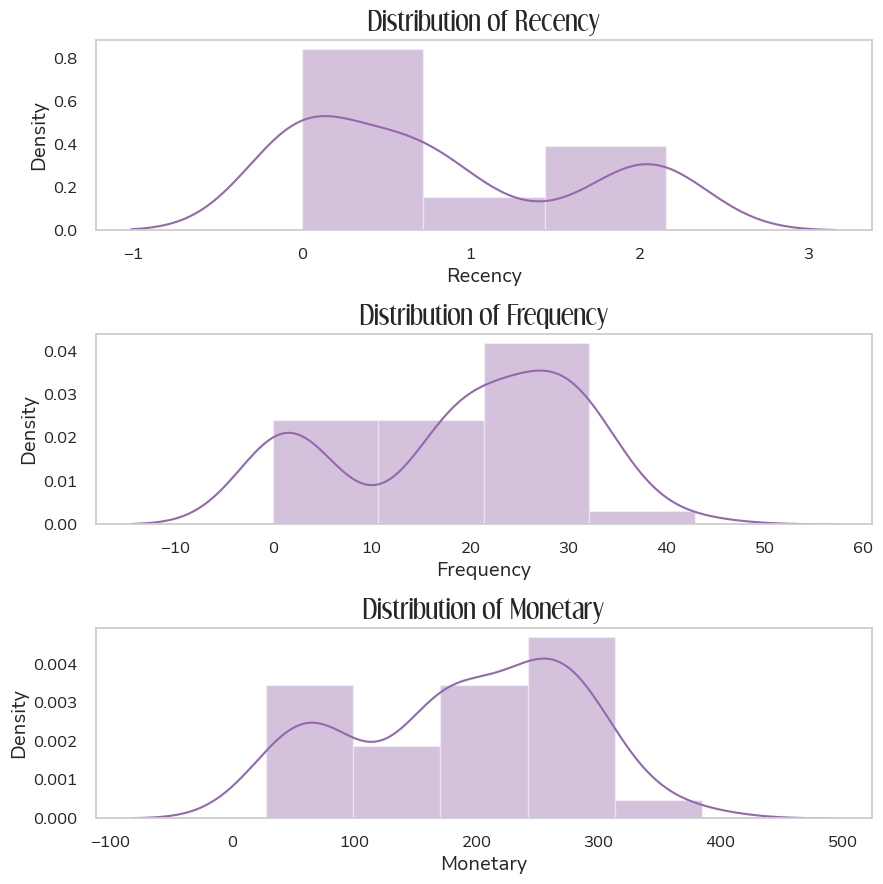

In [79]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(df_net_rfm_bc,'Recency')

plt.subplot(3, 1, 2)
check_skew(df_net_rfm_bc,'Frequency')

plt.subplot(3, 1, 3)
check_skew(df_net_rfm_bc,'Monetary')

plt.tight_layout()

Among different transformations, Box-cox yielded the best results (skew near 0 and pvalue >0.05)

### Scaling

In [80]:
scaler = StandardScaler()
scaler.fit(df_net_rfm_bc)
rfm_net_table_scaled = scaler.transform(df_net_rfm_bc)

In [81]:
rfm_net_table_scaled_df = pd.DataFrame(rfm_net_table_scaled, columns=df_rfm_log.columns)
rfm_net_table_scaled_df.head()

,Recency,Frequency,Monetary
0,-0.973652,1.027079,0.896559
1,1.592645,-1.654406,-1.818004
2,1.453437,-1.458318,-1.505380
3,-0.973652,0.970605,1.044256
4,0.083249,-0.055369,-0.188660


### KMeans

In [82]:
from sklearn.metrics import silhouette_score,  davies_bouldin_score
from scipy.spatial.distance import cdist
# distortions = []

wcss = {} ## Within-Cluster Sum of Square
ssc = {}
calinski_score = {}
davies_score = {}
K = range(2,10)

for k in K:
    #Building and fitting the model
    kmeans_model = KMeans(n_clusters=k, random_state=42).fit(rfm_net_table_scaled_df)
    kmeans_model.fit(rfm_net_table_scaled_df)

    wcss[k] = kmeans_model.inertia_ ### sum of squared distances to closest cluster center
    ssc[k] = silhouette_score(rfm_net_table_scaled_df, kmeans_model.labels_, metric='euclidean')
    davies_score[k] = davies_bouldin_score(rfm_net_table_scaled_df, kmeans_model.labels_)

### Identify Number of Clusters

### The Elbow Method (Cluster = 3)

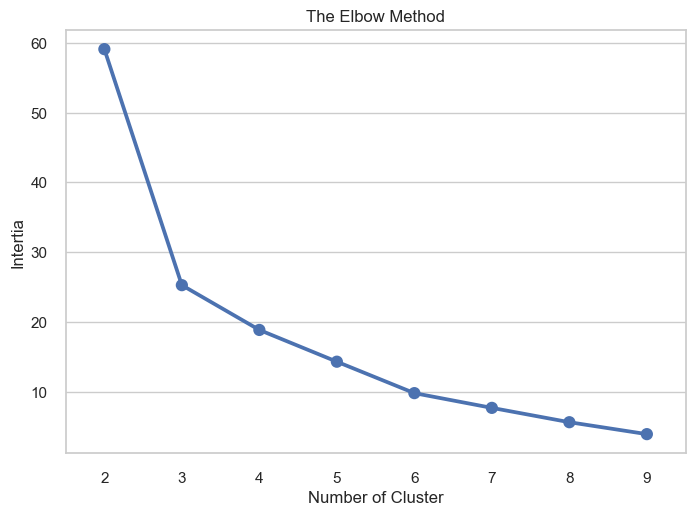

In [83]:
plt.title('The Elbow Method')
plt.xlabel('Number of Cluster')
plt.ylabel('Intertia')
sns.pointplot(x=list(wcss.keys()), y=list(wcss.values()))
plt.show()

In [84]:
from kneed import KneeLocator

cost_kneed = KneeLocator(x = K , y = list(wcss.values()) , S = 1.0 , curve = 'convex' , direction = 'decreasing' , online = True)
suggested_cluster = cost_kneed.elbow
print('Elbow at k = {} clusters'.format(suggested_cluster))

Elbow at k = 3 clusters


### Silhouette Score (2 or 8,9)

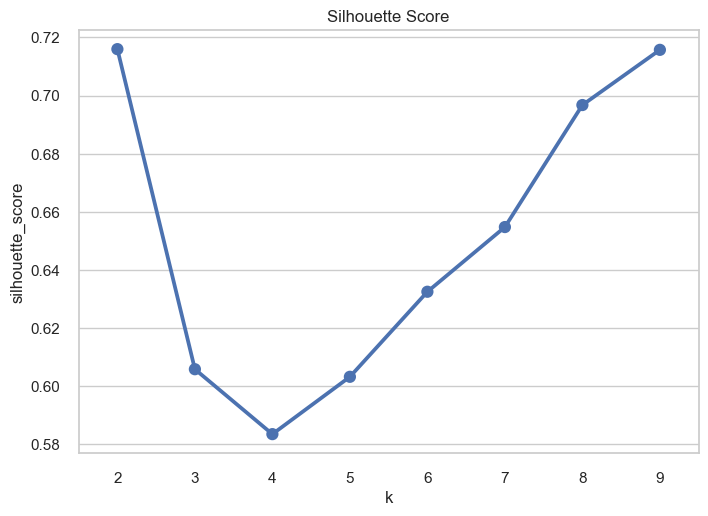

In [86]:
plt.title('Silhouette Score')
plt.xlabel('k')
plt.ylabel('silhouette_score')
sns.pointplot(x=list(ssc.keys()), y=list(ssc.values()))
plt.show()

In [87]:
def silhouette_plot(X , from_k , to_k):
    silhouette_scores = []
    for k in range(from_k , to_k):
        #Instantiate model in k clusters
        model = KMeans(n_clusters = k)
        #Instantiate Visualizer model of with k clusters
        visualizer = SilhouetteVisualizer(model)
        #Fit data to the model
        visualizer.fit(X)
        #Draw data
        visualizer.poof()
        #Append score
        silhouette_scores.append([visualizer.silhouette_score_ , k])
    return silhouette_scores

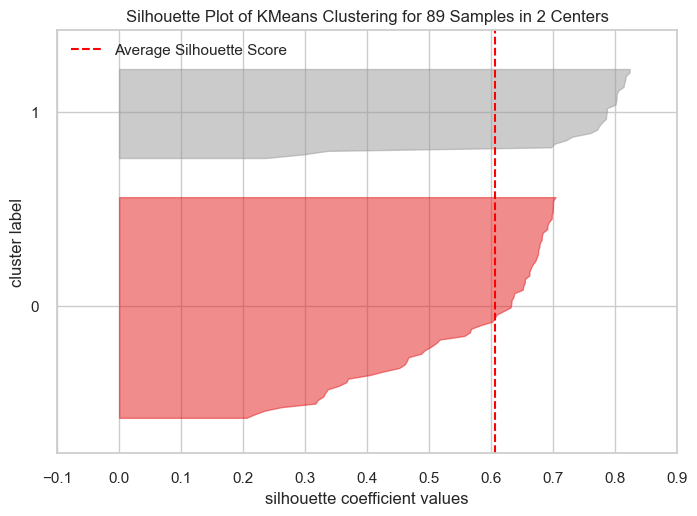

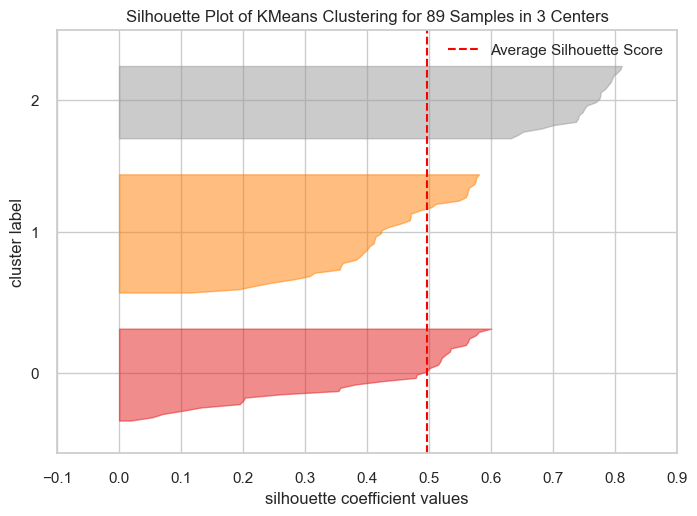

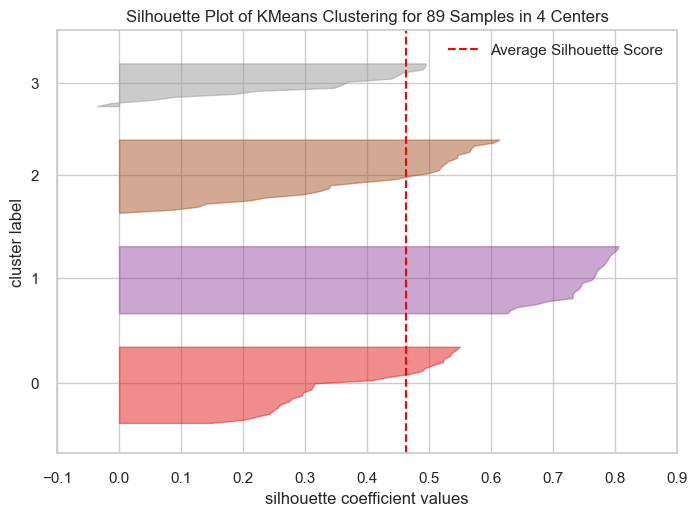

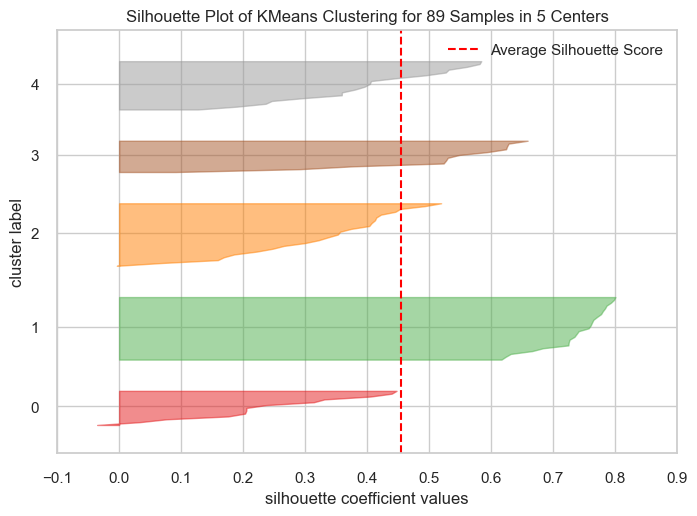

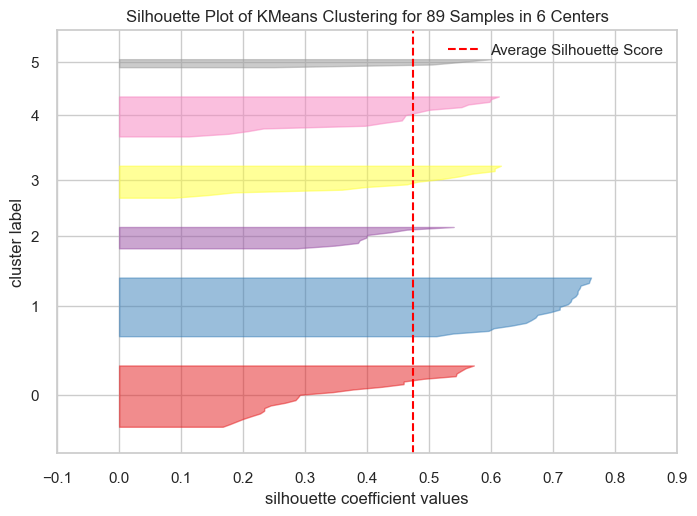

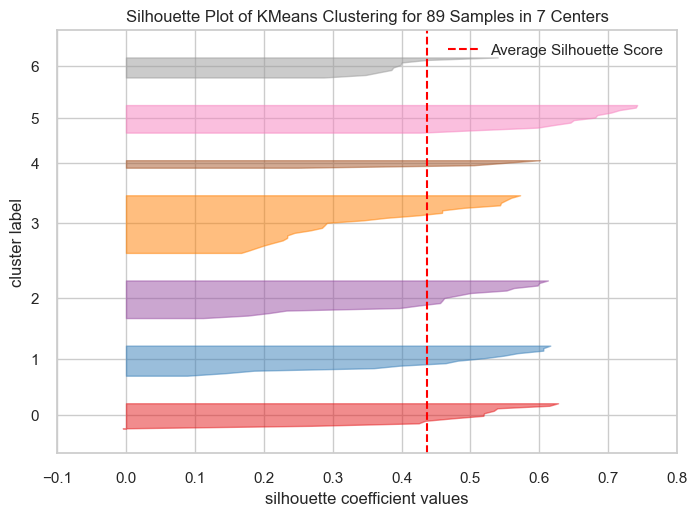

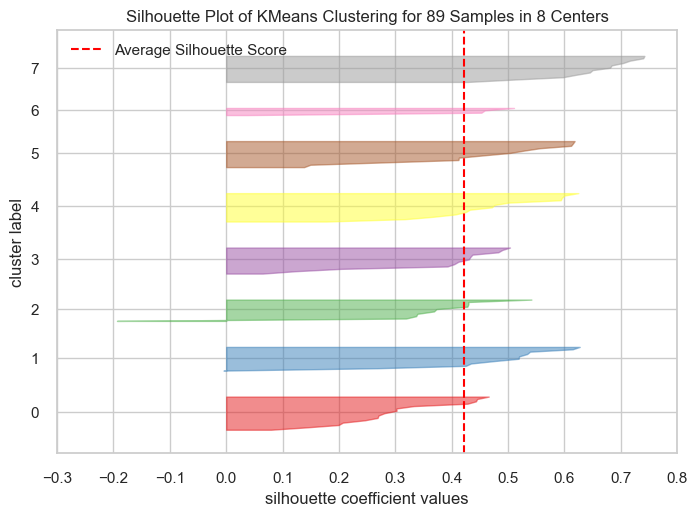

[[0.6058474322548111, 2],
 [0.49718551080512824, 3],
 [0.46240311744640467, 4],
 [0.45464734063466616, 5],
 [0.4736162571843312, 6],
 [0.4370012553366592, 7],
 [0.4220511942120437, 8]]

In [138]:
silhouette_plot(rfm_net_table_scaled_df , 2 , 9)

Graph shows either 2 or 3 as best number of clusters - High Sil. coeff (nearer to 1) and high and above ave. individual/cluster sil. coef values

### Davies Bouldin Score (Cluster = 2)

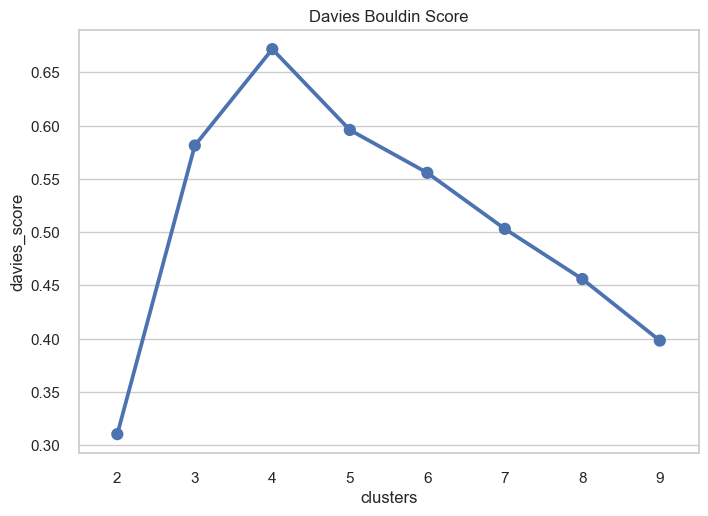

In [89]:
plt.title('Davies Bouldin Score')
plt.xlabel('clusters')
plt.ylabel('davies_score')
sns.pointplot(x=list(davies_score.keys()), y=list(davies_score.values()))
plt.show()

For Davies Bouldin Score, Cluster = 2 has the lowest score

### Visualization

### TSNE Graph

In [90]:
def flattened_graph(normalised_df_rfm, clusters_number, original_df_rfm):

    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_

    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)

    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)

    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")

    return df_new

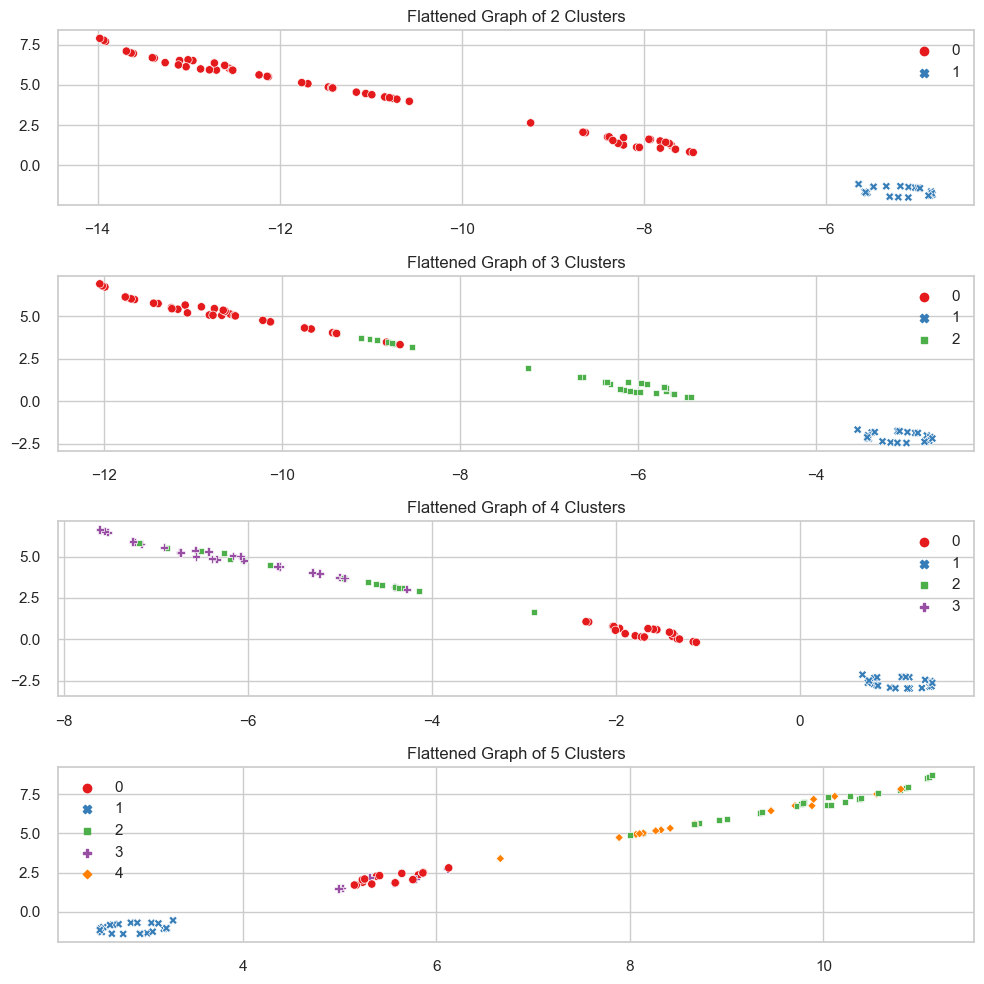

In [91]:
plt.figure(figsize=(10, 10))

plt.subplot(4, 1, 1)
df_rfm_k2 = flattened_graph(rfm_net_table_scaled_df, 2, df_net_agg[['Recency','Frequency','Monetary']])

plt.subplot(4, 1, 2)
df_rfm_k3 = flattened_graph(rfm_net_table_scaled_df, 3, df_net_agg[['Recency','Frequency','Monetary']])

plt.subplot(4, 1, 3)
df_rfm_k4 = flattened_graph(rfm_net_table_scaled_df, 4, df_net_agg[['Recency','Frequency','Monetary']])

plt.subplot(4, 1, 4)
df_rfm_k5 = flattened_graph(rfm_net_table_scaled_df, 5, df_net_agg[['Recency','Frequency','Monetary']])

plt.tight_layout()

### Snake Plot

In [92]:
def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):

    normalised_df_rfm['CustomerID'] = df_rfm_original.index
    normalised_df_rfm['Cluster'] = list(df_rfm_kmeans['Cluster'])

    # # Melt data into long format
    df_melt = pd.melt(normalised_df_rfm,
                        id_vars=['CustomerID', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'Monetary'],
                        var_name='Metric',
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')

    return

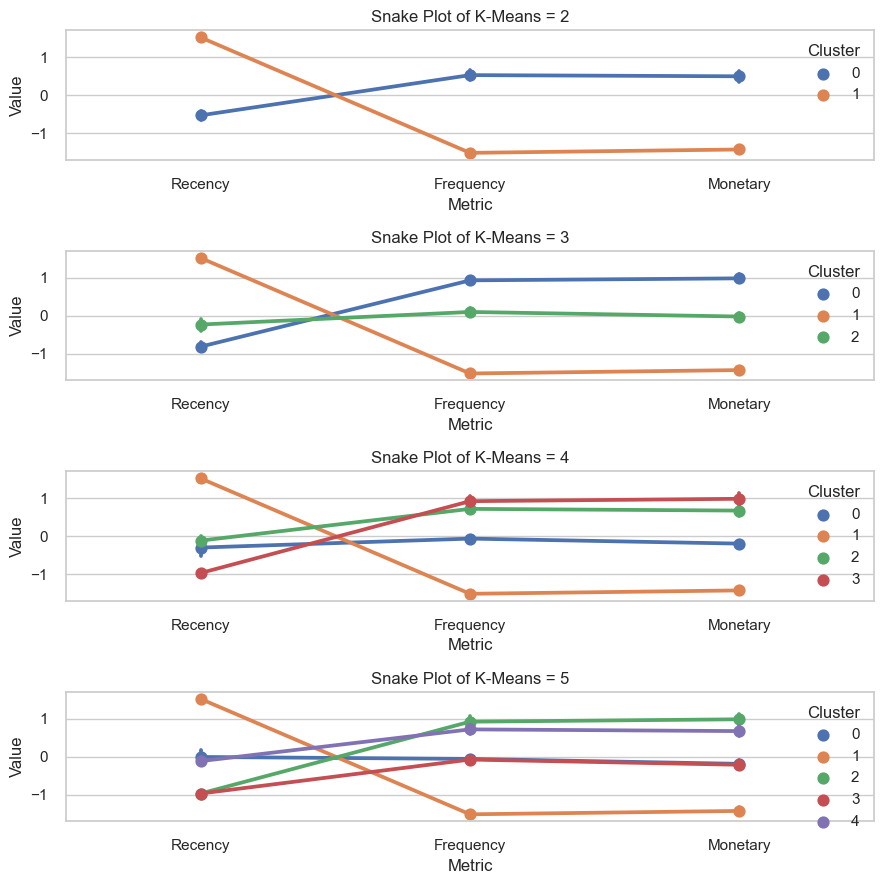

In [93]:
plt.figure(figsize=(9, 9))
plt.subplot(4, 1, 1)
plt.title('Snake Plot of K-Means = 2')
snake_plot(rfm_net_table_scaled_df, df_rfm_k2, df_net_agg[['Recency','Frequency','Monetary']])

plt.subplot(4, 1, 2)
plt.title('Snake Plot of K-Means = 3')
snake_plot(rfm_net_table_scaled_df, df_rfm_k3, df_net_agg[['Recency','Frequency','Monetary']])

plt.subplot(4, 1, 3)

plt.title('Snake Plot of K-Means = 4')
snake_plot(rfm_net_table_scaled_df, df_rfm_k4, df_net_agg[['Recency','Frequency','Monetary']])

plt.subplot(4, 1, 4)
plt.title('Snake Plot of K-Means = 5')
snake_plot(rfm_net_table_scaled_df, df_rfm_k5, df_net_agg[['Recency','Frequency','Monetary']])

plt.tight_layout()

### Count Plot

In [94]:
def countplot(cluster, cluster_number):
  original_scale = df_net_agg[['Recency','Frequency','Monetary']]
  original_scale['Cluster'] = list(cluster['Cluster'])

  sns.catplot(
    data=original_scale,
    x="Cluster",
    kind="count"
  )
  plt.show()

  return

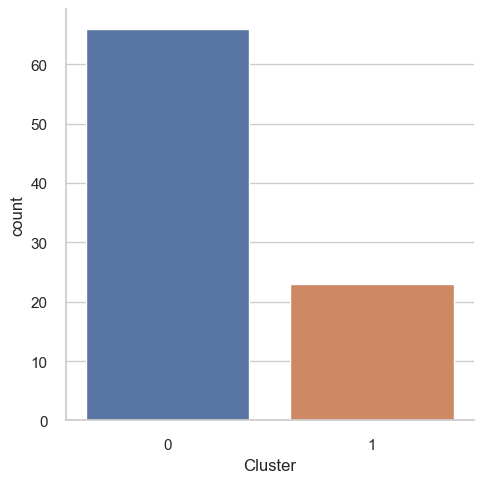

In [95]:
countplot(df_rfm_k2, 2)

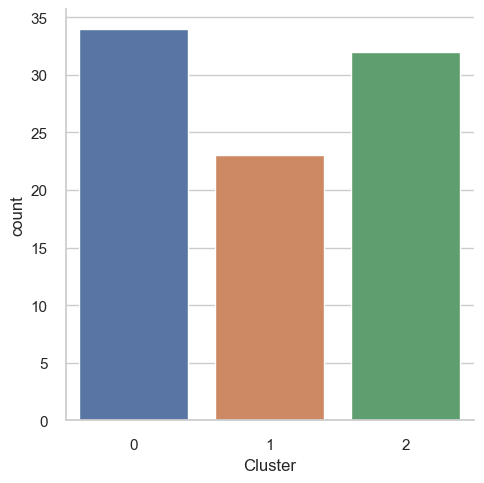

In [96]:
countplot(df_rfm_k3, 3)

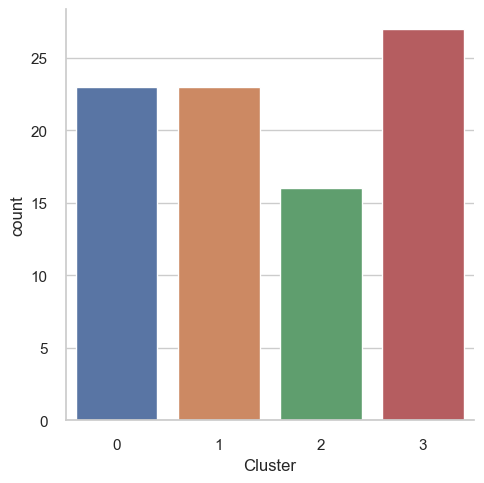

In [97]:
countplot(df_rfm_k4, 4)

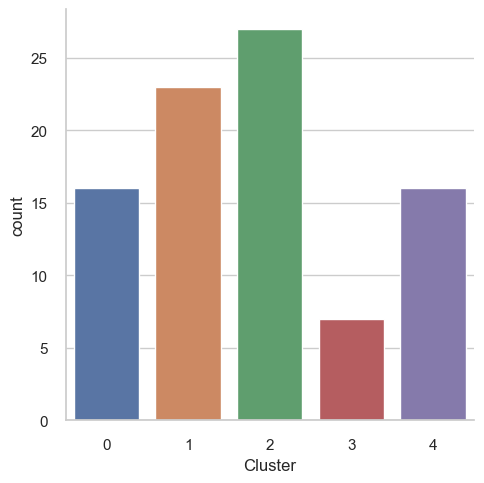

In [98]:
countplot(df_rfm_k5, 4)

Based on number of sample size (n=89), and resulting graphs, 3 is the best cluster.

In [99]:
def rfm_values(df):

    df_new = df.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': ['mean', 'count']
    }).round(0)

    return df_new

In [101]:
rfm_values(df_rfm_k3)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0           1.0     516.0  37140.0    34
1         278.0       4.0   1696.0    23
2           3.0     225.0  16260.0    32

- Cluster 0 - High R, High F, High M (Active, Loyal, High Spender)
- Cluster 1 - Low R, Low F, Low M (Inactive, Not Loyal, Low Spender)
- Cluster 2 - High R, Low F, Low M (Active, Not Loyal, Low Spender) 

### Interpretation

In [102]:
interpret_cluster_result = df_net_agg
interpret_cluster_result['CustomerID'] = df_net_agg.index
interpret_cluster_result['Cluster'] = df_rfm_k3['Cluster']

In [103]:
interpret_cluster_result.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Score,RFM_Level,CustomerID,Cluster
acct_num,,,,,,,,,,
124000000000,1,546,34281.67,3,3,3,9,Top,124000000000,0
138000000000,379,1,286.41,2,2,1,5,Middle,138000000000,1
169000000000,117,5,1201.48,3,3,1,7,Middle,169000000000,1
170000000000,1,521,37966.54,3,3,3,9,Top,170000000000,0
201000000000,3,179,13260.67,3,3,2,8,Top,201000000000,2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


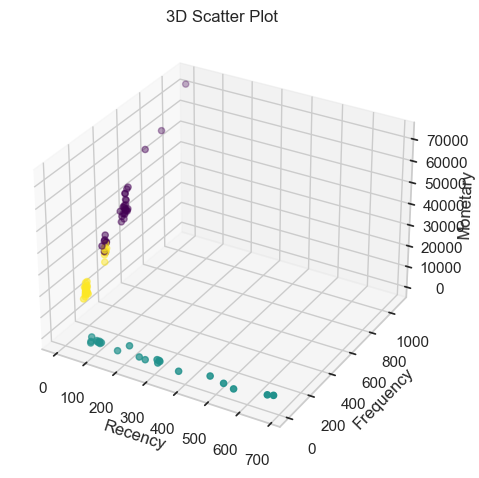

In [104]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
np.random.seed(0)
n_points = 100
x = list(interpret_cluster_result['Recency'])
y = list(interpret_cluster_result['Frequency'])
z = list(interpret_cluster_result['Monetary'])
c = list(interpret_cluster_result['Cluster'])

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data points
scatter = ax.scatter(x, y, z, c=c, cmap="viridis")

# Label the axes
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')


# Set the plot title
plt.title('3D Scatter Plot')

# Display the legend
plt.legend()

# Show the plot
plt.show()

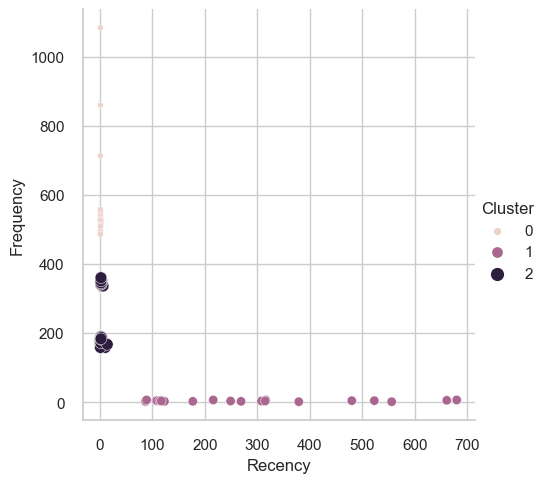

In [105]:
sns.relplot(data=interpret_cluster_result,
            x="Recency",
            y="Frequency",
            hue="Cluster",
            size="Cluster"
            )
plt.show()

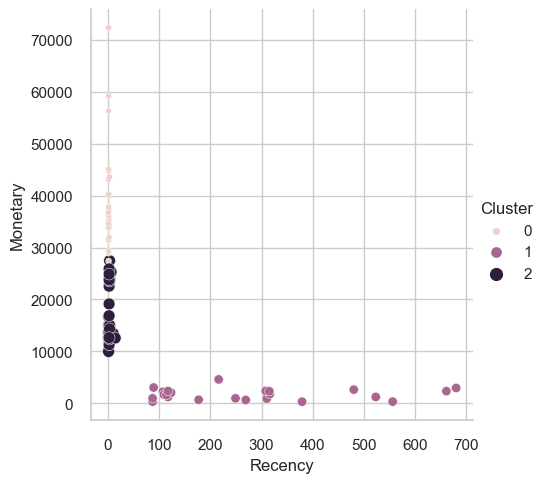

In [106]:
sns.relplot(data=interpret_cluster_result,
            x="Recency",
            y="Monetary",
            hue="Cluster",
            size="Cluster"
            )
plt.show()

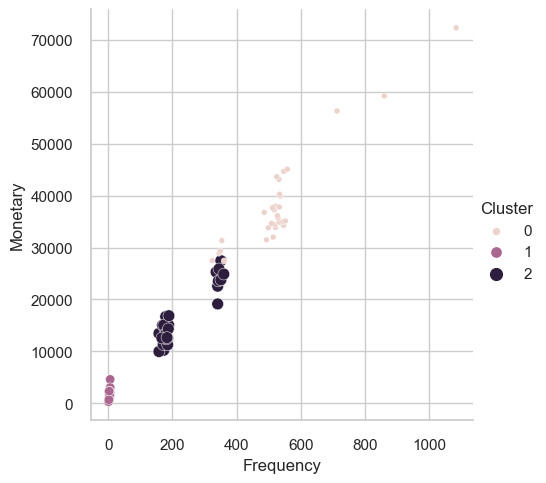

In [107]:
sns.relplot(data=interpret_cluster_result,
            x="Frequency",
            y="Monetary",
            hue="Cluster",
            size="Cluster"
            )
plt.show()

### Boxplot

In [108]:
interpret_cluster_result.loc[interpret_cluster_result['Cluster']==0, 'Cluster'] = 'Cluster 1'
interpret_cluster_result.loc[interpret_cluster_result['Cluster']==1, 'Cluster'] = 'Cluster 2'
interpret_cluster_result.loc[interpret_cluster_result['Cluster']==2, 'Cluster'] = 'Cluster 3'
interpret_cluster_result

,Recency,Frequency,Monetary,R,F,M,RFM_Score,RFM_Level,CustomerID,Cluster
acct_num,,,,,,,,,,
124000000000,1,546,34281.67,3,3,3,9,Top,124000000000,Cluster 1
138000000000,379,1,286.41,2,2,1,5,Middle,138000000000,Cluster 2
169000000000,117,5,1201.48,3,3,1,7,Middle,169000000000,Cluster 2
170000000000,1,521,37966.54,3,3,3,9,Top,170000000000,Cluster 1
201000000000,3,179,13260.67,3,3,2,8,Top,201000000000,Cluster 3
...,...,...,...,...,...,...,...,...,...,...
969000000000,14,167,12560.54,3,3,2,8,Top,969000000000,Cluster 3
971000000000,1,509,34637.90,3,3,3,9,Top,971000000000,Cluster 1
989000000000,2,183,12638.38,3,3,2,8,Top,989000000000,Cluster 3


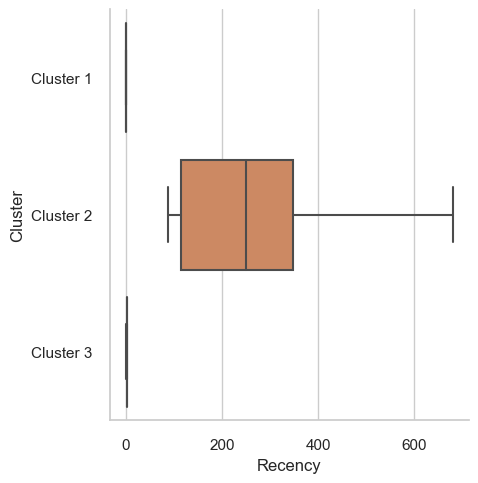

In [109]:
sns.catplot(
    data=interpret_cluster_result,
    x="Recency",
    y="Cluster",
    kind="box",
    sym="",
    order=["Cluster 1", "Cluster 2", "Cluster 3"],
    )
plt.show()

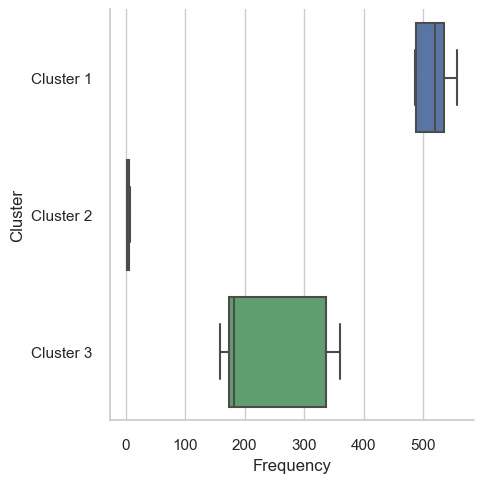

In [110]:
sns.catplot(
    data=interpret_cluster_result,
    x="Frequency",
    y="Cluster",
    kind="box",
    sym="",
    order=["Cluster 1", "Cluster 2", "Cluster 3"]
    )
plt.show()

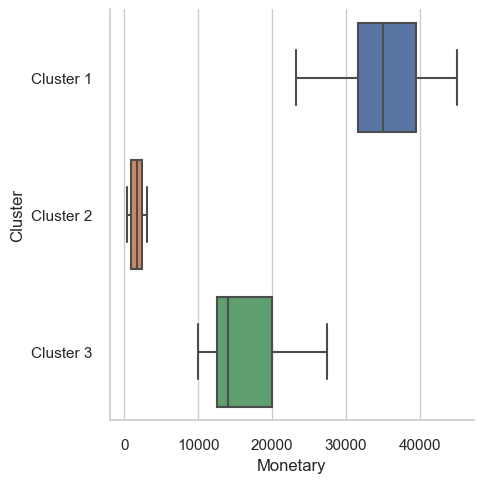

In [111]:
sns.catplot(
    data=interpret_cluster_result,
    x="Monetary",
    y="Cluster",
    kind="box",
    sym="",
    order=["Cluster 1", "Cluster 2", "Cluster 3"]
    )
plt.show()

### Hypothesis Testing

In [112]:
interpret_cluster_result = df_net_agg
interpret_cluster_result['CustomerID'] = df_net_agg.index
interpret_cluster_result['Cluster'] = df_rfm_k3['Cluster']

In [113]:
from scipy.stats import f_oneway

# Perform ANOVA tests for each RFM variable
for rfm_variable in ['Recency', 'Frequency', 'Monetary']:
    # Extract data for each cluster
    cluster_data = [interpret_cluster_result[rfm_variable][interpret_cluster_result['Cluster'] == cluster]
                    for cluster in interpret_cluster_result['Cluster'].unique()]

    # Perform ANOVA test
    f_statistic, p_value = f_oneway(*cluster_data)

    # Output results
    print(f"ANOVA test for {rfm_variable}:")
    print(f"F-statistic: {f_statistic}")
    print(f"P-value: {p_value}")
    if p_value < 0.05:
        print("Statistically significant difference")
    else:
        print("No statistically significant difference")
    print("\n")


ANOVA test for Recency:
F-statistic: 70.99714232383707
P-value: 6.204447475526298e-19
Statistically significant difference


ANOVA test for Frequency:
F-statistic: 178.37025626659016
P-value: 2.506196237399963e-31
Statistically significant difference


ANOVA test for Monetary:
F-statistic: 188.3133936996315
P-value: 3.78887287247168e-32
Statistically significant difference




# Demographics Deep Dive

In [114]:
df_net_agg[['CustomerID','Cluster']]

,CustomerID,Cluster
acct_num,,
124000000000,124000000000,0
138000000000,138000000000,1
169000000000,169000000000,1
170000000000,170000000000,0
201000000000,201000000000,2
...,...,...
969000000000,969000000000,2
971000000000,971000000000,0
989000000000,989000000000,2


In [115]:
df_pos_net.columns

Index(['cc_num', 'gender', 'city', 'city_pop', 'job', 'dob', 'acct_num',
       'trans_num', 'unix_time', 'category', 'amt', 'age', 'trans_date',
       'trans_year', 'trans_month', 'is_ncr', 'gen_cat'],
      dtype='object')

In [116]:
df_pos_net_dem = df_pos_net[['gender', 'city', 'city_pop', 'job', 'acct_num', 'age', 'is_ncr', 'gen_cat']]

In [117]:
df_net_dem = df_pos_net_dem[df_pos_net_dem['gen_cat']=='POS'].drop_duplicates()

In [118]:
df_net_dem

,gender,city,city_pop,job,acct_num,age,is_ncr,gen_cat
14,M,Marikina City,450741,No Job Indicated,34614744133,67.0,0,POS
15,M,Malabon,365525,Broadcast journalist,587000000000,66.0,1,POS
20,M,Laoag,111125,Dance movement psychotherapist,257000000000,68.0,0,POS
25,M,Digos,169393,"Administrator, charities/voluntary organisations",968000000000,53.0,0,POS
28,M,Mati,141141,Psychotherapist,851000000000,53.0,0,POS
...,...,...,...,...,...,...,...,...
44781,M,Marikina City,450741,Youth worker,138000000000,69.0,0,POS
44878,M,Surigao,154137,Software engineer,369000000000,60.0,0,POS
50196,M,Pagadian,199060,Land/geomatics surveyor,236000000000,62.0,0,POS
57626,M,Tuguegarao,153502,Air cabin crew,925000000000,68.0,0,POS


In [119]:
merged_df = pd.merge(df_net_dem, df_net_agg[['CustomerID','Cluster']], on='acct_num', how='left')

In [120]:
merged_df

,gender,city,city_pop,job,acct_num,age,is_ncr,gen_cat,CustomerID,Cluster
0,M,Marikina City,450741,No Job Indicated,34614744133,67.0,0,POS,34614744133,2
1,M,Malabon,365525,Broadcast journalist,587000000000,66.0,1,POS,587000000000,0
2,M,Laoag,111125,Dance movement psychotherapist,257000000000,68.0,0,POS,257000000000,0
3,M,Digos,169393,"Administrator, charities/voluntary organisations",968000000000,53.0,0,POS,968000000000,0
4,M,Mati,141141,Psychotherapist,851000000000,53.0,0,POS,851000000000,0
...,...,...,...,...,...,...,...,...,...,...
166,M,Marikina City,450741,Youth worker,138000000000,69.0,0,POS,138000000000,1
167,M,Surigao,154137,Software engineer,369000000000,60.0,0,POS,369000000000,1
168,M,Pagadian,199060,Land/geomatics surveyor,236000000000,62.0,0,POS,236000000000,1
169,M,Tuguegarao,153502,Air cabin crew,925000000000,68.0,0,POS,925000000000,1


In [121]:
merged_df.value_counts('acct_num')

acct_num
581000000000    6
902000000000    4
845000000000    4
233000000000    4
124000000000    2
               ..
647000000000    1
644000000000    1
470000000000    1
138000000000    1
808000000000    1
Length: 89, dtype: int64

In [122]:
merged_df[merged_df['acct_num']=='581000000000']

,gender,city,city_pop,job,acct_num,age,is_ncr,gen_cat,CustomerID,Cluster
8,M,Malaybalay,174625,English as a foreign language teacher,581000000000,74.0,0,POS,581000000000,0
35,M,San Fernando,306659,"Surveyor, quantity",581000000000,88.0,0,POS,581000000000,0
86,M,Malaybalay,174625,No Job Indicated,581000000000,74.0,0,POS,581000000000,0
149,M,San Fernando,306659,No Job Indicated,581000000000,88.0,0,POS,581000000000,0
158,F,Dipolog,130759,No Job Indicated,581000000000,59.0,0,POS,581000000000,0
162,F,Dipolog,130759,Archivist,581000000000,59.0,0,POS,581000000000,0


In [123]:
merged_pop = merged_df[['city','city_pop','Cluster','acct_num','is_ncr']].drop_duplicates()

## Location

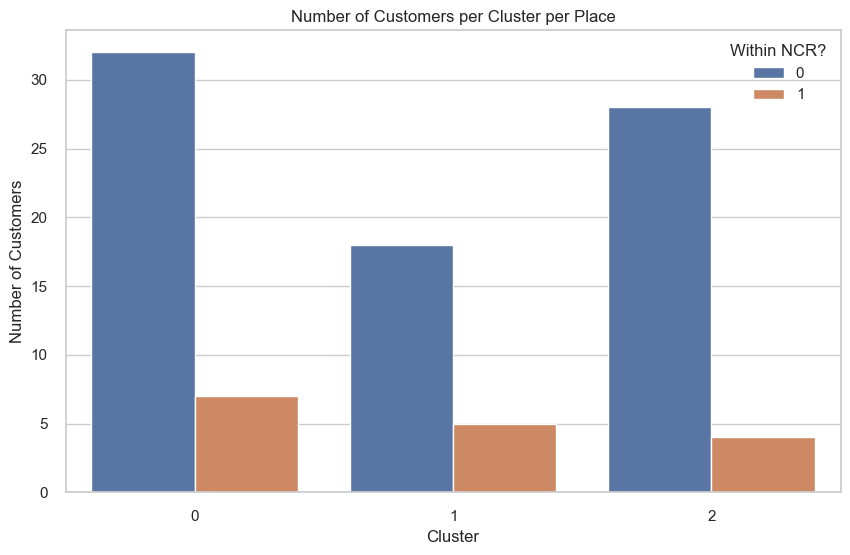

In [124]:
# Create a countplot
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', hue='is_ncr', data=merged_pop)

# Add labels and a title
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.title('Number of Customers per Cluster per Place')

# Show the plot
plt.legend(title='Within NCR?')
plt.show()

In [125]:
avg_pop = merged_pop[['city','city_pop','Cluster']].drop_duplicates()

In [126]:
avg_pop.groupby('Cluster').mean()/1000

,city_pop
Cluster,
0,295.475588
1,298.248450
2,1177.796333


In [127]:
# Number of cities within clusters
avg_pop.groupby('Cluster').size()

Cluster
0    34
1    20
2    27
dtype: int64

### Initial Demographics View
- Cluster 0 - Lower population area, Highly diverse cities
- Cluster 1 - Lower population area, Not as diverse cities (Concentrated)
- Cluster 2 - Highly populated area, diverse cities

In [128]:
count_data = merged_df.groupby(['city', 'Cluster']).size().reset_index(name='Count')
count_data = count_data.sort_values(by='Count', ascending=False)

In [129]:
# count_data[count_data['Cluster']==0]

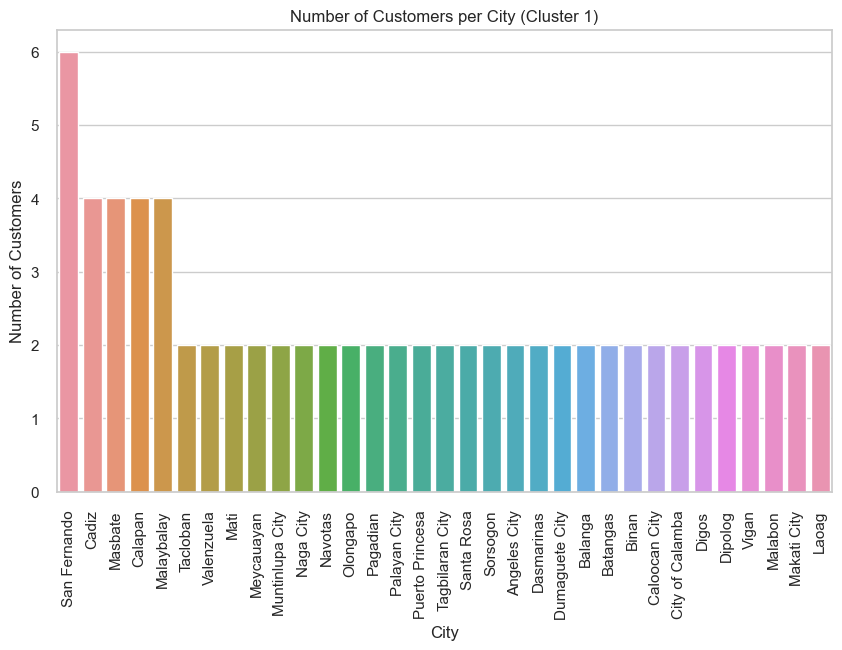

In [130]:
plt.figure(figsize=(10, 6))
sns.barplot(x='city', y='Count', data=count_data[count_data['Cluster']==0])

# Add labels and a title
plt.xlabel('City')
plt.ylabel('Number of Customers')
plt.title('Number of Customers per City (Cluster 1)')

plt.xticks(rotation=90)
# Show the plot
plt.show()

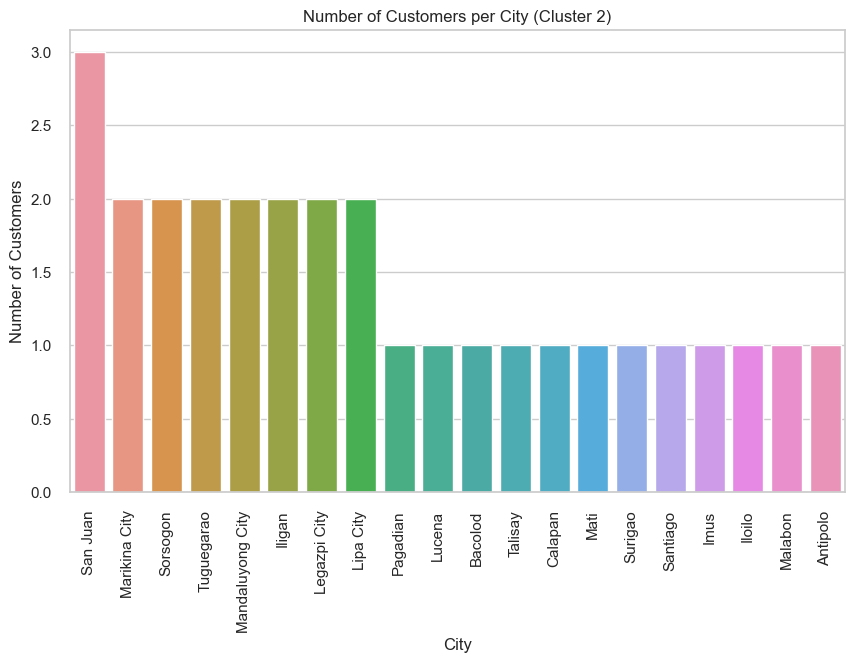

In [131]:
plt.figure(figsize=(10, 6))
sns.barplot(x='city', y='Count', data=count_data[count_data['Cluster']==1])

# Add labels and a title
plt.xlabel('City')
plt.ylabel('Number of Customers')
plt.title('Number of Customers per City (Cluster 2)')

plt.xticks(rotation=90)
# Show the plot
plt.show()

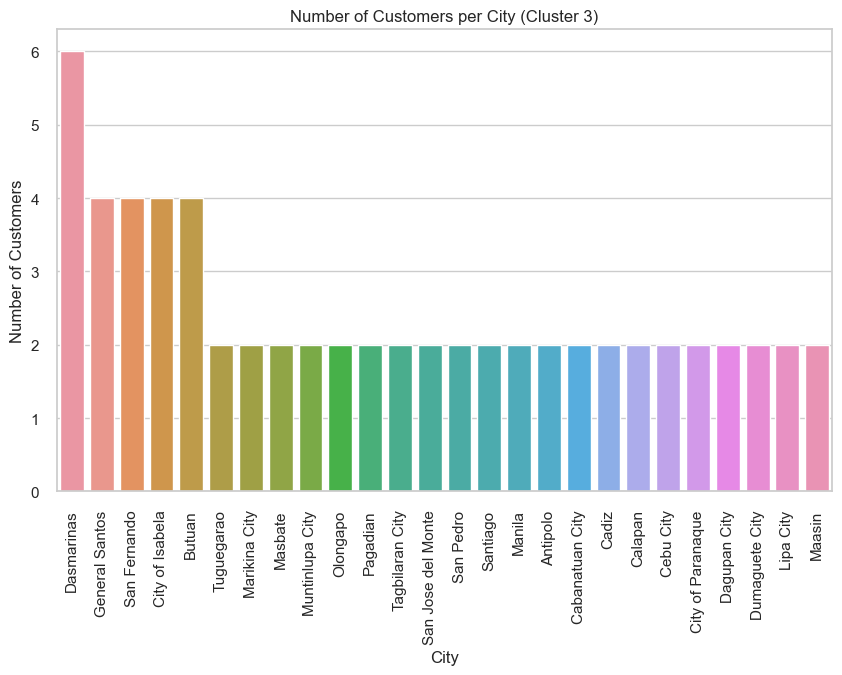

In [132]:
plt.figure(figsize=(10, 6))
sns.barplot(x='city', y='Count', data=count_data[count_data['Cluster']==2])

# Add labels and a title
plt.xlabel('City')
plt.ylabel('Number of Customers')
plt.title('Number of Customers per City (Cluster 3)')

plt.xticks(rotation=90)
# Show the plot
plt.show()

## Gender

In [133]:
merged_gen = merged_df[['acct_num','gender','Cluster']].drop_duplicates()

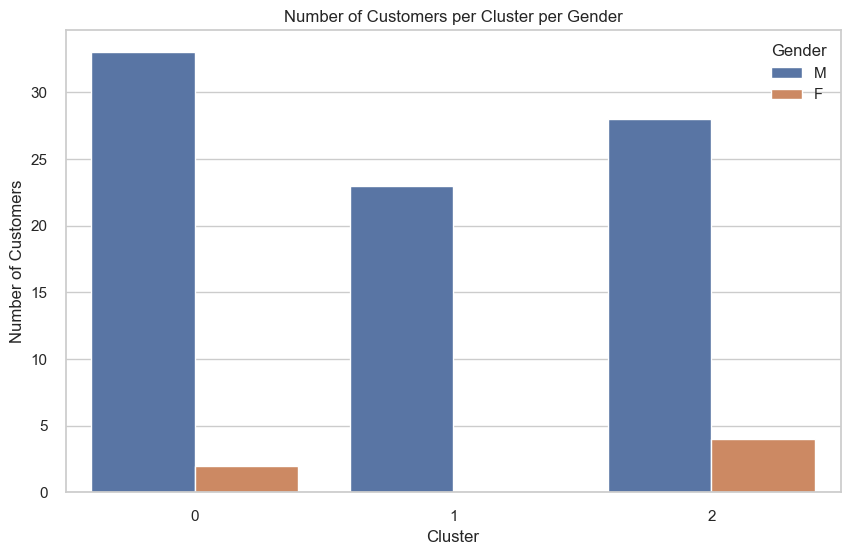

In [134]:
# Create a countplot
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', hue='gender', data=merged_gen)

# Add labels and a title
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.title('Number of Customers per Cluster per Gender')

# Show the plot
plt.legend(title='Gender')
plt.show()

In [135]:
merged_gen.groupby(['Cluster','gender']).size()

Cluster  gender
0        F          2
         M         33
1        M         23
2        F          4
         M         28
dtype: int64

## Job

In [136]:
merged_job = merged_df[['acct_num','job','Cluster']].drop_duplicates()

In [137]:
merged_job[merged_job['Cluster']==0].value_counts('job')

job
No Job Indicated                                             34
Tourist information centre manager                            2
Psychotherapist                                               2
Administrator, charities/voluntary organisations              1
Research scientist (medical)                                  1
Manufacturing systems engineer                                1
Operational investment banker                                 1
Public relations account executive                            1
Radiographer, diagnostic                                      1
Research officer, political party                             1
Scientific laboratory technician                              1
Aid worker                                                    1
Social worker                                                 1
Surveyor, planning and development                            1
Surveyor, quantity                                            1
Teacher, early years/pre            

In [138]:
job_0 = merged_job[merged_job['Cluster']==0]['job'].drop_duplicates().to_list()

In [139]:
text_0 = ' '.join(job_0)

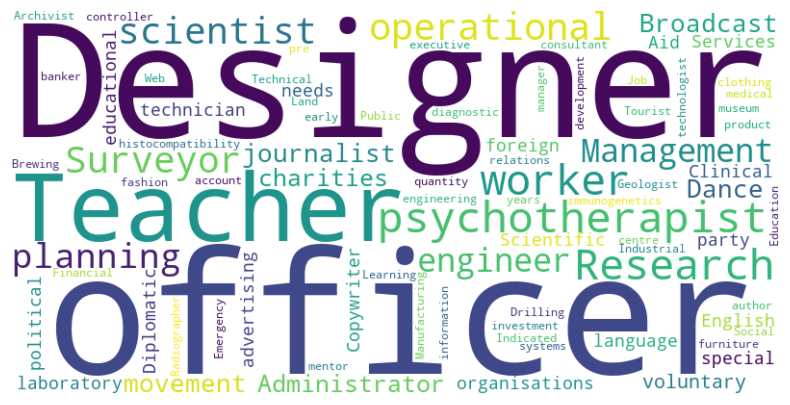

In [140]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_0)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [141]:
merged_job[merged_job['Cluster']==0].value_counts('job')

job
No Job Indicated                                             34
Tourist information centre manager                            2
Psychotherapist                                               2
Administrator, charities/voluntary organisations              1
Research scientist (medical)                                  1
Manufacturing systems engineer                                1
Operational investment banker                                 1
Public relations account executive                            1
Radiographer, diagnostic                                      1
Research officer, political party                             1
Scientific laboratory technician                              1
Aid worker                                                    1
Social worker                                                 1
Surveyor, planning and development                            1
Surveyor, quantity                                            1
Teacher, early years/pre            

Active, Loyal, and High Spender Group (First List):
- Tactile Experience: Creative professionals, such as designers and artists, may prefer onsite shopping to physically examine materials, textures, and colors. This tactile experience is essential for their work.

- Personal Interaction: Many individuals in this population are involved in roles that require personal interactions. They may value the social aspects of onsite shopping, including interacting with store staff and other shoppers.

- Specialized Equipment: Professionals like engineers and scientists may require specialized equipment and tools that are more readily available through onsite suppliers or stores.

- Cultural and Artistic Exploration: Given the presence of roles like archivists, dance movement psychotherapists, and diplomats, some individuals in this group may engage in cultural or artistic exploration that involves visiting physical locations, galleries, or specialty stores.

- Community Support: Professionals in charitable organizations and social work may prefer to support local businesses and communities by shopping onsite, aligning with their values of social responsibility.

In [142]:
job_1 = merged_job[merged_job['Cluster']==1]['job'].drop_duplicates().to_list()
text_1 = ' '.join(job_1)

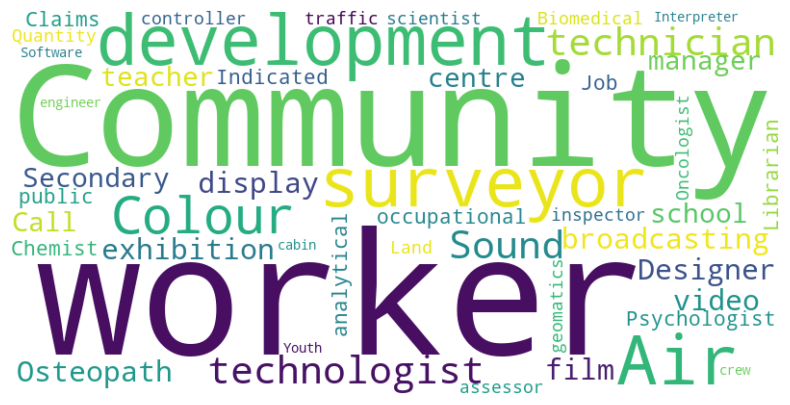

In [144]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_1)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [145]:
merged_job[merged_job['Cluster']==1].value_counts('job')

job
No Job Indicated                             6
Land/geomatics surveyor                      2
Osteopath                                    2
Air traffic controller                       1
Sound technician, broadcasting/film/video    1
Software engineer                            1
Secondary school teacher                     1
Quantity surveyor                            1
Psychologist, occupational                   1
Oncologist                                   1
Librarian, public                            1
Air cabin crew                               1
Interpreter                                  1
Development worker, community                1
Designer, exhibition/display                 1
Community development worker                 1
Colour technologist                          1
Claims inspector/assessor                    1
Chemist, analytical                          1
Call centre manager                          1
Biomedical scientist                         1
Youth wor

Low Spender, Low Loyalty, and Inactive Group (Second List):


In [146]:
job_2 = merged_job[merged_job['Cluster']==2]['job'].drop_duplicates().to_list()
text_2 = ' '.join(job_2)

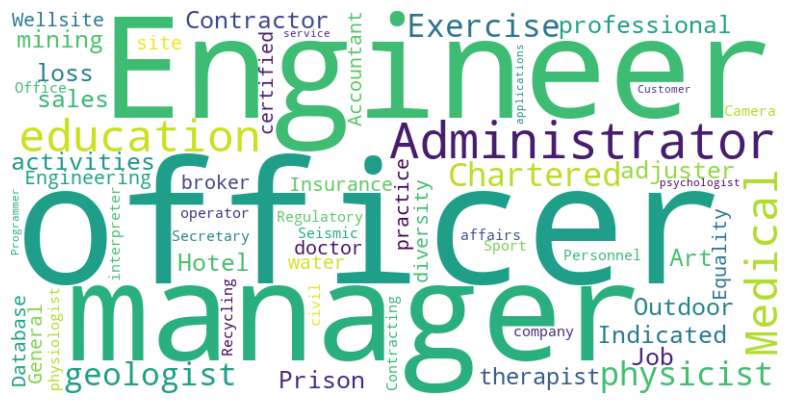

In [147]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_2)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [148]:
merged_job[merged_job['Cluster']==2].value_counts('job')

job
No Job Indicated                        32
Accountant, chartered certified          1
IT sales professional                    1
Sport and exercise psychologist          1
Seismic interpreter                      1
Secretary, company                       1
Regulatory affairs officer               1
Recycling officer                        1
Programmer, applications                 1
Prison officer                           1
Physicist, medical                       1
Personnel officer                        1
Outdoor activities/education manager     1
Office manager                           1
Medical physicist                        1
Insurance broker                         1
Hotel manager                            1
Administrator, education                 1
General practice doctor                  1
Exercise physiologist                    1
Equality and diversity officer           1
Engineering geologist                    1
Engineer, water                          1
Enginee

Low and Mid 

 - Preference for Online Shopping: Individuals in this group may prefer online shopping because their professions or personal preferences may not require frequent or significant in-person shopping. For example, professionals like "Software engineer" or "Psychologist, occupational" might find online shopping more convenient due to their busy schedules or tech-savvy nature.

- Tech-Savvy: Many professions in this group, such as "Software engineer" and "Claims inspector/assessor," involve technology or data analysis, which could make them more comfortable with online shopping platforms.

- Limited Time for Onsite Shopping: Professions like "Air traffic controller" and "Air cabin crew" often involve irregular schedules, making it challenging to find time for onsite shopping. Online shopping allows them to shop at their convenience.

- Specific Needs: Some professions, such as "Chemist, analytical" and "Biomedical scientist," may have specialized needs for laboratory equipment or materials that are not easily found in physical stores.

- Less Loyalty to Onsite Shopping: Since these individuals may have limited time for onsite shopping and may find online options more convenient, they may not be as loyal to traditional brick-and-mortar stores.

- Less In-Person Engagement: Their professions or lifestyles may not involve as much in-person social interaction, reducing the need for onsite shopping for social or professional purposes.

- Influence of Technology: Roles like "Sound technician, broadcasting/film/video" and "Designer, exhibition/display" may be influenced by technological advancements and digital tools, making online shopping a more natural fit.

- Non-Traditional Work Environments: Some professions, like "Community development worker" and "Youth worker," may involve non-traditional work environments that don't require formal onsite shopping.

- Flexible Workstyles: Individuals in tech-related roles or creative professions may have more flexible workstyles that allow them to shop online at any time.


## Category

In [153]:
df_net_trans = df_pos_net[df_pos_net['gen_cat']=='POS']
merged_df_net_trans = pd.merge(df_net_trans, df_net_agg[['CustomerID','Cluster']], on='acct_num', how='left').drop_duplicates()
merged_cat = merged_df_net_trans.groupby(['acct_num','category','Cluster']).agg({'CustomerID':'nunique'}).reset_index()

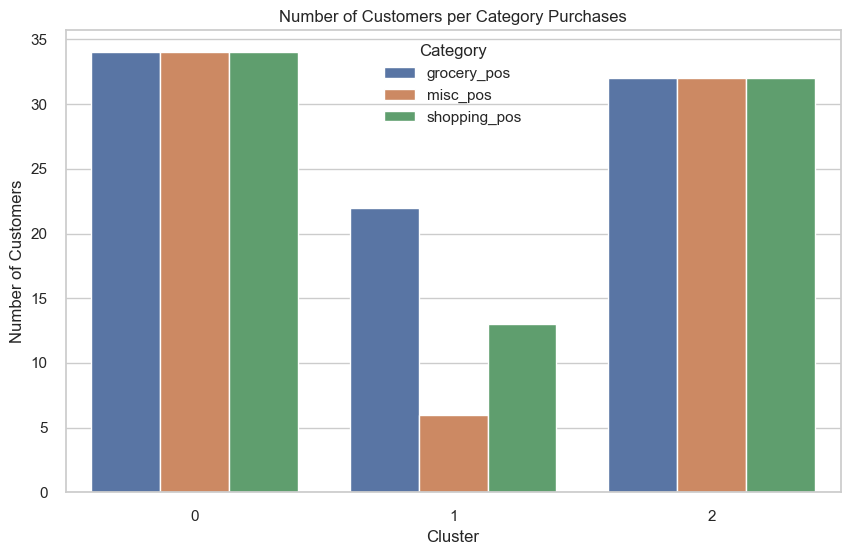

In [154]:
# Create a countplot
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', hue='category', data=merged_cat)

# Add labels and a title
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.title('Number of Customers per Category Purchases')

# Show the plot
plt.legend(title='Category')
plt.show()

## Age

In [155]:
merged_age = merged_df[['acct_num','age','Cluster']].drop_duplicates()

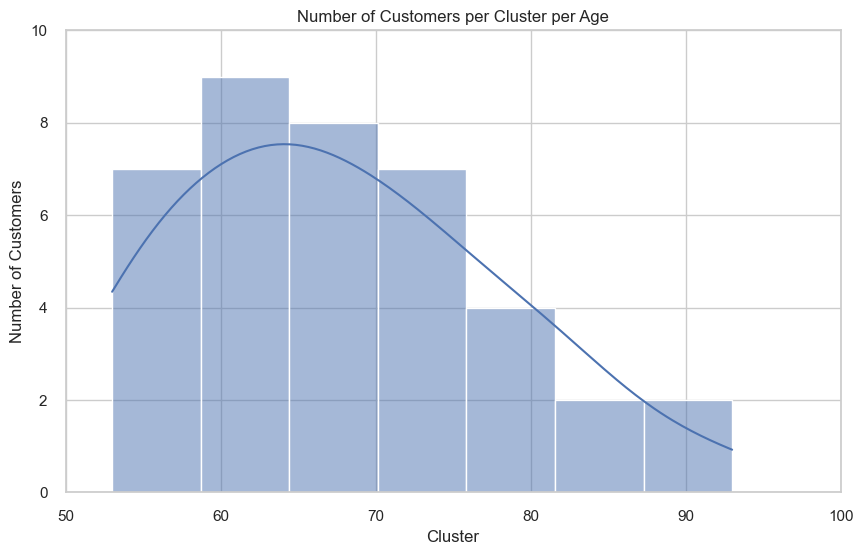

In [156]:
# Create a countplot
plt.figure(figsize=(10, 6))
sns.histplot(x='age', data=merged_age[merged_age['Cluster']==0], kde=True)

# Add labels and a title
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.title('Number of Customers per Cluster per Age')
plt.xlim(50,100)
plt.ylim(0,10)

# Show the plot
plt.show()

In [157]:
merged_age[merged_age['Cluster']==0]['age'].mean()

67.71794871794872

In [158]:
merged_age[merged_age['Cluster']==0]['age'].min()

53.0

In [159]:
merged_age[merged_age['Cluster']==0]['age'].max()

93.0

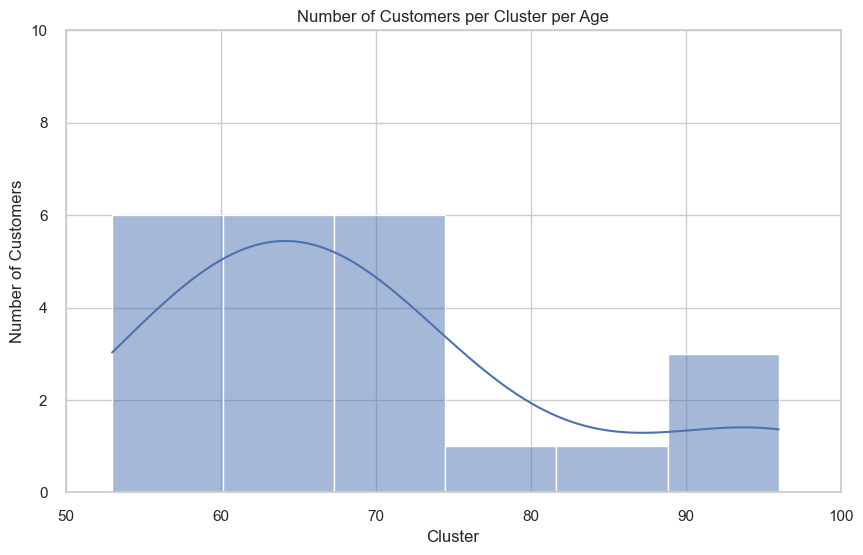

In [160]:
# Create a countplot
plt.figure(figsize=(10, 6))
sns.histplot(x='age', data=merged_age[merged_age['Cluster']==1], kde=True)

# Add labels and a title
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.title('Number of Customers per Cluster per Age')
plt.xlim(50,100)
plt.ylim(0,10)

# Show the plot
plt.show()

In [161]:
merged_age[merged_age['Cluster']==1]['age'].mean()

69.08695652173913

In [162]:
merged_age[merged_age['Cluster']==1]['age'].min()

53.0

In [163]:
merged_age[merged_age['Cluster']==1]['age'].max()

96.0

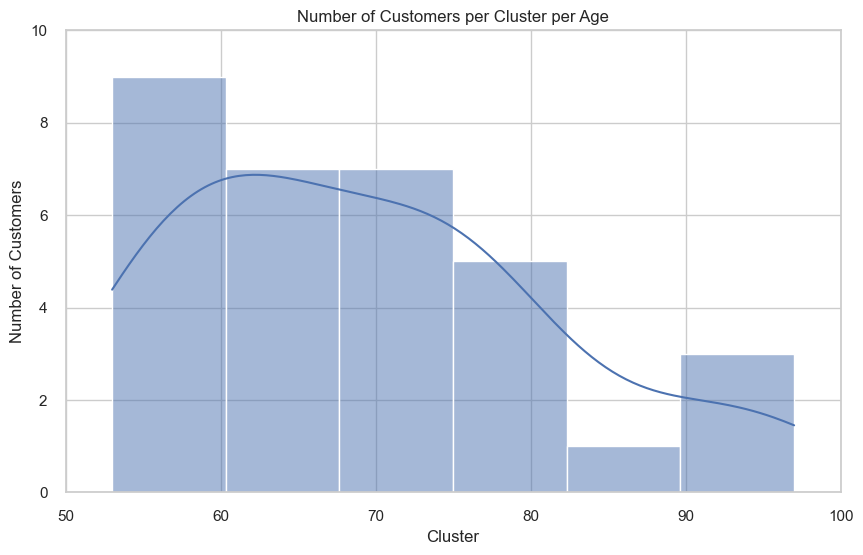

In [164]:
# Create a countplot
plt.figure(figsize=(10, 6))
sns.histplot(x='age', data=merged_age[merged_age['Cluster']==2], kde=True)

# Add labels and a title
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.title('Number of Customers per Cluster per Age')
plt.xlim(50,100)
plt.ylim(0,10)

# Show the plot
plt.show()

In [165]:
merged_age[merged_age['Cluster']==2]['age'].mean()

69.4375

In [166]:
merged_age[merged_age['Cluster']==2]['age'].min()

53.0

In [167]:
merged_age[merged_age['Cluster']==2]['age'].max()

97.0

In [169]:
# df_net_agg.to_csv('cluster_pos.csv')